# Exploring the Relationship Between Economic Indicators and the Successful Arrest rate in the City of Chicago

In [1]:
import pandas as pd
import numpy as np
import time, datetime
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_datareader import DataReader
import geopandas as gpd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
from IPython.display import display
import requests
from bs4 import BeautifulSoup
from sklearn import tree

## Introduction

Researchers have come to find that throughout the last few years, Chicago’s arrest rate and clearance rate have been decreasing steadily, while crime rates increase (Bloomberg, 2023). Additionally, we see a great amount of variation in economic welfare between the 77 communities throughout this time (Semuels, 2021). In light of this data, this study focuses on studying the relationship between economic welfare and the SAR in order to better understand the socioeconomic factors associated with it, if any. The study uses a range of different variables that provide measures of economic welfare, such as the unemployment rate, a hardship index, the percent of households below poverty, among others. In addition, variables reporting the total number of reports and arrests are also used as predictors of the SAR. 

This is a relationship that has yet to be explored in this context, likely because of the difficulty of obtaining data that adequately represents the economic welfare of all communities of a city over a lengthy time period, such as twenty years, and over many variables, such as unemployment, birth rate, etc… Additionally, the successful arrest rate is not generally used as a measure of police effectiveness, but due to limitations on the available data, it had to be used in place of the clearance rate. 

With this being said, a plethora of studies conducted have analyzed the causational relationship between a specific socioeconomic measure and arrest rates. Notably, “Youth, Underemployment, and Property Crime: Differential Effects of Job Availability and Job Quality on Juvenile and Young Adult Arrest Rates”, conducted by Emilie Allan and Darrell Steffensmeier, which studies the relationship between underemployment and the arrest rate among young adults (1989). 

Likewise, “The Effect of Changes in Intraracial Income Inequality and Educational Attainment on Changes in Arrest Rates for African Americans and Whites, 1957 to 1990”, conducted by Gary LaFree and Kriss Drass, which studies the relationship between income inequality, educational attainment, and the arrest rate (1996).

In contrast to the previous studies, this paper focuses on the communities of Chicago City, Illinois over the 2002-2022 period. By analyzing the observed data, we can gain insights into the potential influence of socioeconomic factors on the SAR and further our understanding of the complex relationship between crime and social conditions in Chicago.

## Project One

### 1.1 - Loading the Datasets

In [2]:
# Loading the Crime data (Cleaning process shown above)
cleaned_chicago_crime = pd.read_csv('FinalCrimeData.csv')

In [3]:
# the below dataset is the complete version including the added datasets from Project 3
final_data = pd.read_csv('FinalData.csv')
# the below dataset contains only the data that was accessible at the point of Project 1
incomplete_final_data = final_data[['Community Area', 'Community Area Name', 'Year', 'Total Reports', 'Total Arrests', 'Successful Arrest Rate']]

In [169]:
cleaned_chicago_crime.head()

,ID,Date,Block,Primary Type,Description,Location Description,Arrest,Domestic,District,Community Area,Year,Latitude,Longitude,Community Name
0,10224738,09/05/2015 01:30:00 PM,043XX S WOOD ST,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,9.0,61.0,2015,41.815117,-87.670000,NEW CITY
1,10224832,09/04/2015 05:00:00 PM,013XX W 50TH ST,THEFT,$500 AND UNDER,RESIDENCE,False,True,9.0,61.0,2015,41.803227,-87.658360,NEW CITY
2,10224834,09/05/2015 02:00:00 PM,051XX S PAULINA ST,THEFT,$500 AND UNDER,STREET,False,False,9.0,61.0,2015,41.800729,-87.667199,NEW CITY
3,10224945,09/05/2015 05:40:00 PM,053XX S LAFLIN ST,PUBLIC PEACE VIOLATION,ARSON THREAT,RESIDENCE PORCH/HALLWAY,True,True,9.0,61.0,2015,41.796919,-87.662233,NEW CITY
4,10224948,09/05/2015 12:20:00 PM,051XX S HONORE ST,BURGLARY,UNLAWFUL ENTRY,APARTMENT,False,False,9.0,61.0,2015,41.800627,-87.670846,NEW CITY


### 1.2 - Summary Statistics

#### 1.2.1 - The Individual Crime Dataset

In [4]:
# Listing all variables in the dataset
columns = cleaned_chicago_crime.columns
# Format the column names
formatted_column_names = " | ".join(columns)

# Print the formatted column names
print("Column names: {}".format(formatted_column_names))
print('Total Number of observations: ', cleaned_chicago_crime.shape[0], 'reports between', min(cleaned_chicago_crime['Year']), 'and', max(cleaned_chicago_crime['Year']))

Column names: ID | Date | Block | Primary Type | Description | Location Description | Arrest | Domestic | District | Community Area | Year | Latitude | Longitude | Community Name
Total Number of observations:  7008734 reports between 2002 and 2022


Variable Descriptions:

- 'ID': Unique case-identifying number

- 'Block': Block on which the crime occured

- 'Primary Type': The type of crime reported; takes a total of 35 unique values

- 'Description' : Brief description of the crime

- 'Location Description': Brief description of where the crime occured; takes on a total of 214 unique values

- 'Arrest': Boolean variable labeled "False" if no arrest was made for the report, and "True" if an arrest has been made

- 'Domestic': Boolean variable labeled "False" if the comitted crime was not in a domestic/familial setting, and "True" otherwise

- 'District': The Police District in which the crime occured

- 'Community Area': Community Area in which the crime occured; takes a total of 77 unique values

- 'Year': Year the crime was committed

- 'Latitude': Latitude of the reported crime

- 'Longitude': Longitude of the reported crime

- 'Community Name': Name of the Community in which the crime occured


In [5]:
# Calculating the ten most repeated values for the following columns: 'Date', 'Year', 'Block', 'Prinary Type', 'Community Name'
# Ordering the most repeated values
vc_date = cleaned_chicago_crime["Date"].value_counts().sort_values(ascending = False)
vc_year = cleaned_chicago_crime["Year"].value_counts().sort_values(ascending = False)
vc_cn = cleaned_chicago_crime["Community Name"].value_counts().sort_values(ascending = False)
# Getting the ten most repeated values
vc_date10 = vc_date.head(10).reset_index()
vc_year5 = vc_year.head(5).reset_index()
vc_cn5 = vc_cn.head(5).reset_index()
# Turning them into respective dataframes
df_date = pd.DataFrame(vc_date10)
df_year = pd.DataFrame(vc_year5)
df_cn = pd.DataFrame(vc_cn5)

In [6]:
# Renaming the columns
date_col = {'Date': 'Count', 'index': 'Date'}
year_col = {'Year': 'Count', 'index': 'Year'}
cn_col = {'Community Name': 'Count', 'index': 'Community Name'}

df_date = df_date.rename(columns = date_col)
df_year = df_year.rename(columns = year_col)
df_cn = df_cn.rename(columns = cn_col)

In [7]:
print('The Five Most Crime-Ridden Days:')
df_date

The Five Most Crime-Ridden Days:


,Date,Count
0,01/01/2007 12:01:00 AM,172
1,01/01/2008 12:01:00 AM,166
2,01/01/2012 12:01:00 AM,156
3,01/01/2007 12:00:00 AM,145
4,01/01/2003 12:00:00 AM,140
5,01/01/2003 12:01:00 AM,139
6,01/01/2011 12:01:00 AM,136
7,01/01/2016 12:01:00 AM,132
8,01/01/2004 12:00:00 AM,132
9,01/01/2010 12:01:00 AM,130


From the figure above, we can see that the ten most crime-ridden days are all on the same day and relatively the same time, but different years, with the date being January 1. Considering that this is the most popular day of the entire calender year, it is intuitive that there would be a more-than-regular number of crimes. However, seeing as the time is just past 12:00 AM, some confusion is raised regarding the situation. The likely reason behind this is that the police officers have incentive, such as increase in wage, to record these crimes as part of the next year, meaning they wait until midnight to do so.

In [8]:
print('The Five Most Crime-Ridden Years:')
df_year

The Five Most Crime-Ridden Years:


,Year,Count
0,2003,471989
1,2004,467119
2,2005,449867
3,2006,445488
4,2007,435529


Through the figure above we can infer that the five most crime-ridden years are not too far apart in total total reported crimes, with the differnce between first and fifth place being approximately 35,500 reports. However, it is interesting to note how the five years are chronoligcally consistent and not random throughout the twenty-year period.

In [9]:
print('The Five Most Crime-Ridden Communities:')
df_cn

The Five Most Crime-Ridden Communities:


,Community Name,Count
0,AUSTIN,439805
1,NEAR NORTH SIDE,245822
2,SOUTH SHORE,231573
3,HUMBOLDT PARK,219359
4,NEAR WEST SIDE,210886


The most important piece of information that can be taken from the above figure depicting the five most crime-ridden communmities is the massive difference observed between first place, Austin, and second place, Near North Side. We see a difference of approximately 194,000 more crimes reported in Austin. Additionally, a relatively small difference is observed between Near North Side and the next three most crime-ridden communities.

In [10]:
# Creating a Correlation Matrix of relevant variables
correlation_matrix = cleaned_chicago_crime[["Arrest", "Domestic", "Community Area"]]
correlation_matrix = correlation_matrix.corr()
correlation_matrix

,Arrest,Domestic,Community Area
Arrest,1.000000,-0.066386,-0.001843
Domestic,-0.066386,1.000000,0.078142
Community Area,-0.001843,0.078142,1.000000


The correlation matrix above allows us to observe the relationship between the different measured variables available in our dataset. We see a very low correlation between: arrest and domestic (-0.06), and arrest and community area (-0.0018), which is important as it shows us that the crime's domestic status and its community area are not directly associated for the crime's arrest status. However, this does not rule out the possibility of either of these two variables playing a part in the SAR as they could be indirect influencers.

#### 1.2.2 - The Community-Level Crime Dataset

In [11]:
# Listing all variables in the dataset
columns = incomplete_final_data.columns
# Format the column names
formatted_column_names = " | ".join(columns)

# Print the formatted column names
print("Column names: {}".format(formatted_column_names))
print('')
print('Total Number of observations: ', incomplete_final_data.shape[0], 'for 77 communities across', min(incomplete_final_data["Year"]), 'and', max(incomplete_final_data['Year']))
print('')

Column names: Community Area | Community Area Name | Year | Total Reports | Total Arrests | Successful Arrest Rate

Total Number of observations:  1617 for 77 communities across 2002 and 2022



Variable Descriptions:

- Community Area: Community Number
- Year: Year of observations
- Total Reports: Total number of crimes reported
- Total Arrests: Total number of arrests made
- Successful Arrest Rate: Rate of Crimes for which an arrest has been made

In [12]:
print('Descriptive Statistics:')
print('')
desc = incomplete_final_data.describe().round(1)
df_desc = pd.DataFrame(desc)
df_desc = df_desc.drop('Community Area', axis =1)
df_desc = df_desc.drop('Year', axis =1)
df_desc

Descriptive Statistics:



,Total Reports,Total Arrests,Successful Arrest Rate
count,1617.0,1617.0,1617.0
mean,4334.4,1128.1,0.2
std,3900.7,1420.4,0.1
min,234.0,11.0,0.0
25%,1530.0,268.0,0.2
50%,2962.0,581.0,0.2
75%,6178.0,1540.0,0.3
max,30627.0,13423.0,0.5


Although the above table presents a lot of useful information, the most important aspect of it is that it demonstrates the large amount of variety observed. Through the relatively large standard deviations and the large range for all three variables, it can very easily be seen that the data has a lot of variation and is fairly right-skewed.

In [13]:
df_corr = incomplete_final_data.copy()
df_corr = df_corr.drop('Community Area', axis=1)
corr = df_corr.corr().round(2)
print('Correlation Table:')
corr

Correlation Table:


,Year,Total Reports,Total Arrests,Successful Arrest Rate
Year,1.00,-0.27,-0.32,-0.51
Total Reports,-0.27,1.00,0.94,0.53
Total Arrests,-0.32,0.94,1.00,0.68
Successful Arrest Rate,-0.51,0.53,0.68,1.00


The table above shows a positive correlation between total arrests and the SAR, at 0.68, which is relatively expected considering that the SAR includes total arrests in its measurement. In addition, the table shows a moderately positive correlation between total reports and the SAR, at approximately, 0.53, which is not intuitive since it is expected that the more reports filed, the less resources departments are able to allocate per report, leading to a lower SAR; however, this does not appear to be the case. Therefore, it is highly likely that there are other variables, specifically socioeconomic, that contribute to this surprising result.

### 1.3 - Plots and Figures

<AxesSubplot:title={'center':'The Most Reported Crimes in Chicago from 2002-2022'}, xlabel='Number of Reports (in Millions)', ylabel='Crime Type'>

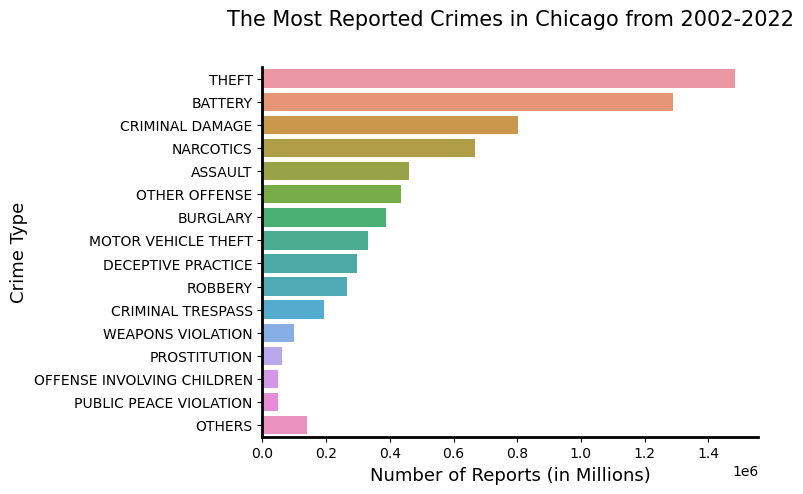

In [177]:
# visualizing the different types of crime comitted
crime_types = cleaned_chicago_crime["Primary Type"].value_counts()
comitted_least_often = crime_types[~(crime_types > 40000)].sum()
crime_types = pd.concat([crime_types[crime_types > 40000], pd.Series([comitted_least_often], index=["OTHERS"])])
crime_types_graph = sns.barplot(x=crime_types.values, y=crime_types.index)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("The Most Reported Crimes in Chicago from 2002-2022", size = 15, pad = 30)
plt.xlabel("Number of Reports (in Millions)", size = 13)
plt.ylabel("Crime Type", size = 13)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
crime_types_graph

The above graph shows the most reported crimes in Chicago over the last 20 years. "Theft" is the most reported crime, closely followed by "Battery," which is defined as the use of force against another that results in harmful contact. This helps us see that the variety of crimes being reported is relatively small, with the top four most reported crimes representing nearly half of all the reported crimes in that time. 

This, paired with the previously identified low SAR, could mean that we are witnessing the same criminals commit the same offense multiple times since they are not being caught, rather than a large pool of criminal offenders comitting the same crime. Alternatively, the police department could have a difficulty with limiting and making arrests for these specific crimes, making them more common compared to others. In order to further analyze this, the following graph will illustrate the types of crime for which the most arrests have been made.

<AxesSubplot:title={'center':'Crimes With the Most Arrests in Chicago from 2002-2022'}, xlabel='Number of Arrests (in Hundreds of Thousands)', ylabel='Crime Type'>

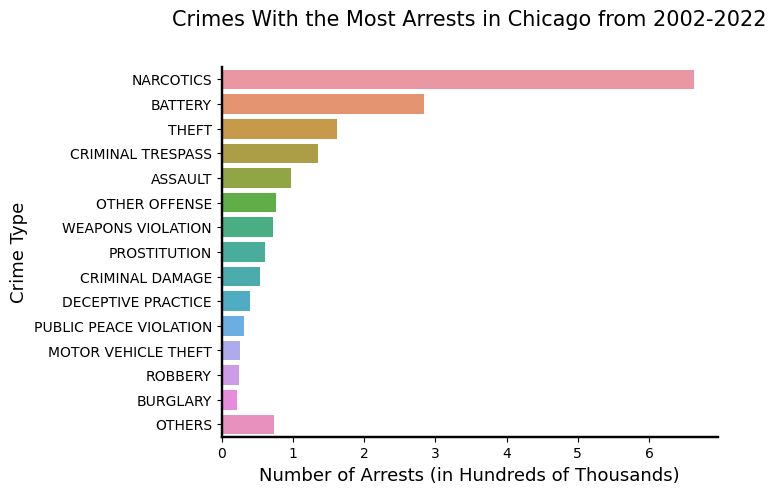

In [180]:
# visualizing the crimes with the most arrests
# filtering for only the subset of crimes for which an arrest has been made
arrested = cleaned_chicago_crime[cleaned_chicago_crime['Arrest'] == True]


crime_types = arrested["Primary Type"].value_counts()
arrested_least_often = crime_types[~(crime_types > 20000)].sum()
crime_types = pd.concat([crime_types[crime_types > 20000], pd.Series([arrested_least_often], index=["OTHERS"])])
crime_types_graph = sns.barplot(x=(crime_types.values / 100000), y=crime_types.index)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.title("Crimes With the Most Arrests in Chicago from 2002-2022", size = 15, pad = 30)
plt.xlabel('Number of Arrests (in Hundreds of Thousands)', size = 13)
plt.ylabel("Crime Type", size = 13)
plt.gca().spines['bottom'].set_linewidth(1.75)
plt.gca().spines['left'].set_linewidth(1.75)

crime_types_graph

As specified above, this graph visualizes the crimes with the most arrests throughout the twenty-year period. "Narcotics" takes the position of being the crime with the most arrests, having over double the amount of arrests as second place, "Battery". Importantly, "Theft", the highest reported crime, is only the third highest in terms of arrests, suggesting that a very large majority of theft crimes are without an arrest. These results follow along with the previously stated hypothesis, and show that the SAR varies significantly among the different crimes committed.

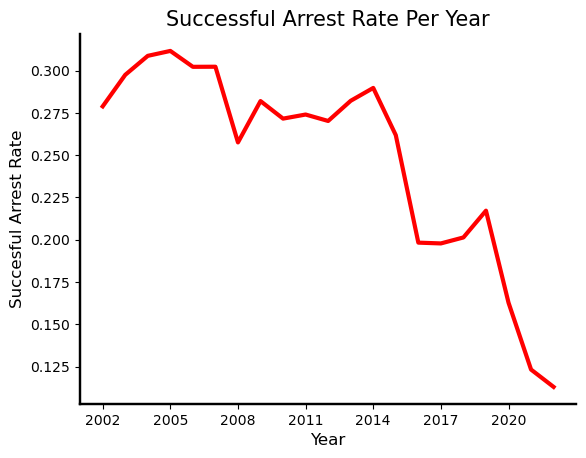

In [181]:
# Visualizing the arrest rate for each year

# grouping the DataFrame by year
grouped = cleaned_chicago_crime.groupby(cleaned_chicago_crime['Year'])

# calculating the average arrests each year
mean_arrests = grouped["Arrest"].mean()

# plotting the average of arrests per year
mean_arrests.plot(kind='line', linewidth = 3, color = 'r')

plt.title('Successful Arrest Rate Per Year', fontsize = 15)
plt.xlabel('Year', size = 12)
plt.ylabel('Succesful Arrest Rate', size = 12)
plt.xticks(range(2002,2023, 3))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(1.75)
plt.gca().spines['left'].set_linewidth(1.75)

plt.show()

Here, we see a visualization of the Succesful Arrest Rate of each year over the last 20 years in Chicago. Most importantly, there is a clear downward trend, showing that the SAR is likely to continue decreasing for the forseeable future. There is a global maximum of the observed data in 2004, where the rate reached as high as 30%; apart from this peak, we see a local maxima approximately 10 years later in 2014 at about 28.5%, but no point in the recent past comes close to this number. The global minimum of the data lies in 2022, the most recent set of observations collected.

These observations promote the research question and leads us to conduct further analysis to determine the economic variables associated with the decreasing SAR.

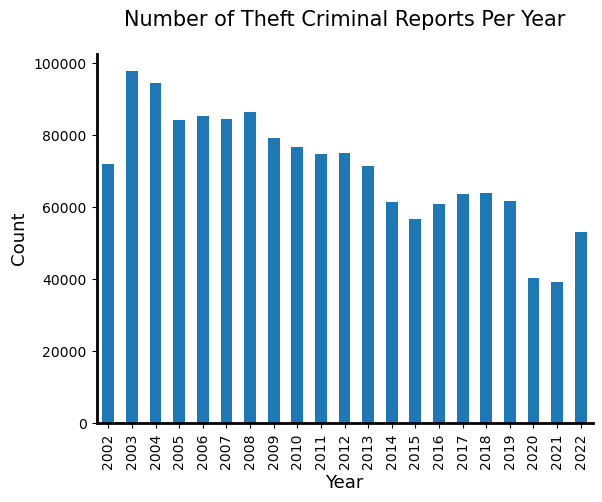

In [17]:
# Visualizing how many "theft" reports for each year
grouped = cleaned_chicago_crime.loc[cleaned_chicago_crime['Primary Type'] == "THEFT"].groupby(cleaned_chicago_crime["Year"])

# getting the number of reports per year
count = grouped["Primary Type"].count()
count.plot(kind = "bar")

plt.title('Number of Theft Criminal Reports Per Year', size = 15, pad = 20)
plt.xlabel('Year', size = 13)
plt.ylabel('Count', size = 13)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.show()

Above is a bar chart representing the number of "Theft" reported crimes throughout the last 20 years. Surprisingly, the number of reports is generally on a decreasing trend, with the average being around 60,000 reports a year. This is useful in demonstrating that the most reported crime type has had decreasing numbers of reports over the years. 

This could imply that Police Departments are targetting the most reported crimes and is putting most of its resources into ensuring that those decrease, which would then result in a general decrease of successful crime arrest rate as they no longer prioritize some of the lesser committed crimes. However, the following graph provides sufficient evidence to disprove this idea.

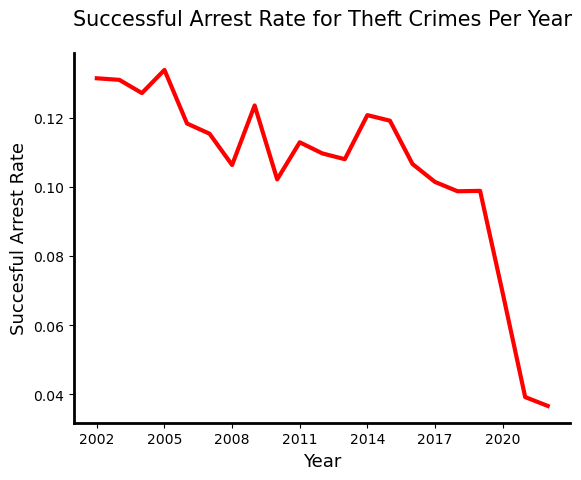

In [18]:
# Graphing the Successful arrest rate for Theft crimes per year

# grouping the DataFrame by year
grouped = cleaned_chicago_crime.loc[cleaned_chicago_crime['Primary Type'] == "THEFT"].groupby(cleaned_chicago_crime["Year"])

# calculating the average arrests each year
mean_arrests = grouped["Arrest"].mean()

# plotting the average of arrests per year
mean_arrests.plot(kind='line', linewidth = 3, color = 'r')

plt.title('Successful Arrest Rate for Theft Crimes Per Year', size = 15, pad = 20)
plt.xlabel('Year', size = 13)
plt.ylabel('Succesful Arrest Rate', size = 13)
plt.xticks(range(2002,2023, 3))
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

plt.show()

This graph represents the SAR for theft per year starting from 2002 up until 2022. Surprisingly, the succesful arrest rate for theft appears to be decreasing as time goes on. Having already been at a relatively low rate in 2002 with a rate of about 0.14%, the successful arrest rate decreased to below 0.04% in 2022. This instantly disproves the above presented theory as these results do not align with the theory's predictions of the CPD's actions. Furthemore, this shows the rapid decrease in the successful arrest rate for the most reported crime in the last 20 years, something that is very unlikely to happen coincidently.

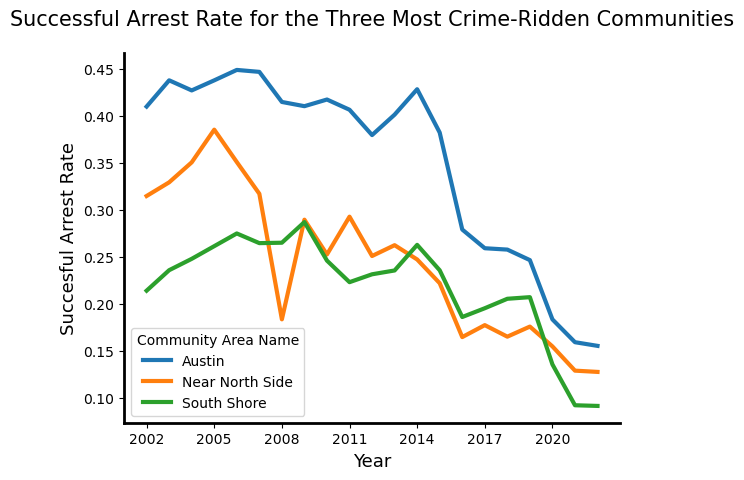

In [19]:
df_ans = incomplete_final_data[incomplete_final_data['Community Area Name'].isin( ['Austin', 'Near North Side', 'South Shore'])]
df_ans = df_ans[['Successful Arrest Rate', 'Year', 'Community Area Name']]

df_pivot = df_ans.pivot(index = 'Year', columns='Community Area Name', values='Successful Arrest Rate')
df_pivot.plot(kind = 'line', linewidth = 3)

plt.xticks(range(2002,2023, 3))
plt.title('Successful Arrest Rate for the Three Most Crime-Ridden Communities', size = 15, pad = 20)
plt.xlabel('Year', size = 13)
plt.ylabel('Succesful Arrest Rate', size = 13)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)

The figure above depicts the decrease in SAR observed in the three most crime-ridden communities over a twenty-year period. We see that at the start, in 2002, there was a moderate difference between all three communities, with Austin, the most crime-ridden community, having an SAR as high as 0.4. However, as we move further to the right, we see the difference between these communities' SAR decrease significantly as the SAR itself decreases. Seeing as there is quite a lot of variation between the communities, the decrease suggests that there are other variables playing a role in the outcome that we see.

## Project Two

### 2.1 - The Message

As discussed above, the SAR varies a lot by year, and at the community-level. This paper aims to study the variables related to the decreasing SAR which are mostly varied at the community-level as well. Therefore, it is important to be able to analyze the difference in these variables between communities in order to study any associations between communities that are related to the SAR. Geographical maps plotting the variables at the community-level allows us to better visualize the difference among communities, and helps us see any links to the SAR that are prominent. Therefore, the following graphical maps will plot different observed variables at the community-level to help us visualize the community-by-community differences.

### 2.2 - Maps and Interpretations

In [20]:
# Loading the geospatial file containing the info needed to plot the maps at a community-level
chicago_districts_map = gpd.read_file('geo_export_1a362191-f64c-4fb6-8c48-28666f5f924f.shp')
chicago_districts_map = chicago_districts_map.sort_values("area_numbe")
chicago_districts_map["Community Area"] = chicago_districts_map["area_numbe"].astype(int)

In [21]:
# Keeping only the data originally used at this portion of the project
grouped_comm = final_data[['Community Area', 'Year', 'Total Reports', 'Total Arrests', 'Successful Arrest Rate']]
grouped_comm.head()

,Community Area,Year,Total Reports,Total Arrests,Successful Arrest Rate
0,1.0,2002,5899,1694,0.287167
1,1.0,2003,7628,2324,0.304667
2,1.0,2004,7587,2232,0.294187
3,1.0,2005,7484,2547,0.340326
4,1.0,2006,7155,2529,0.353459


In [22]:
# Creating the maps that visualize the difference in the successful arrest rate across the last years
grouped_comm_2002 = grouped_comm.loc[grouped_comm["Year"] == 2002]
grouped_comm_2022 = grouped_comm.loc[grouped_comm["Year"] == 2022]

# Mergint the data with the geospatial information
mer_2002 = chicago_districts_map.merge(grouped_comm_2002, on = "Community Area")
mer_2022 = chicago_districts_map.merge(grouped_comm_2022, on = "Community Area")

[]

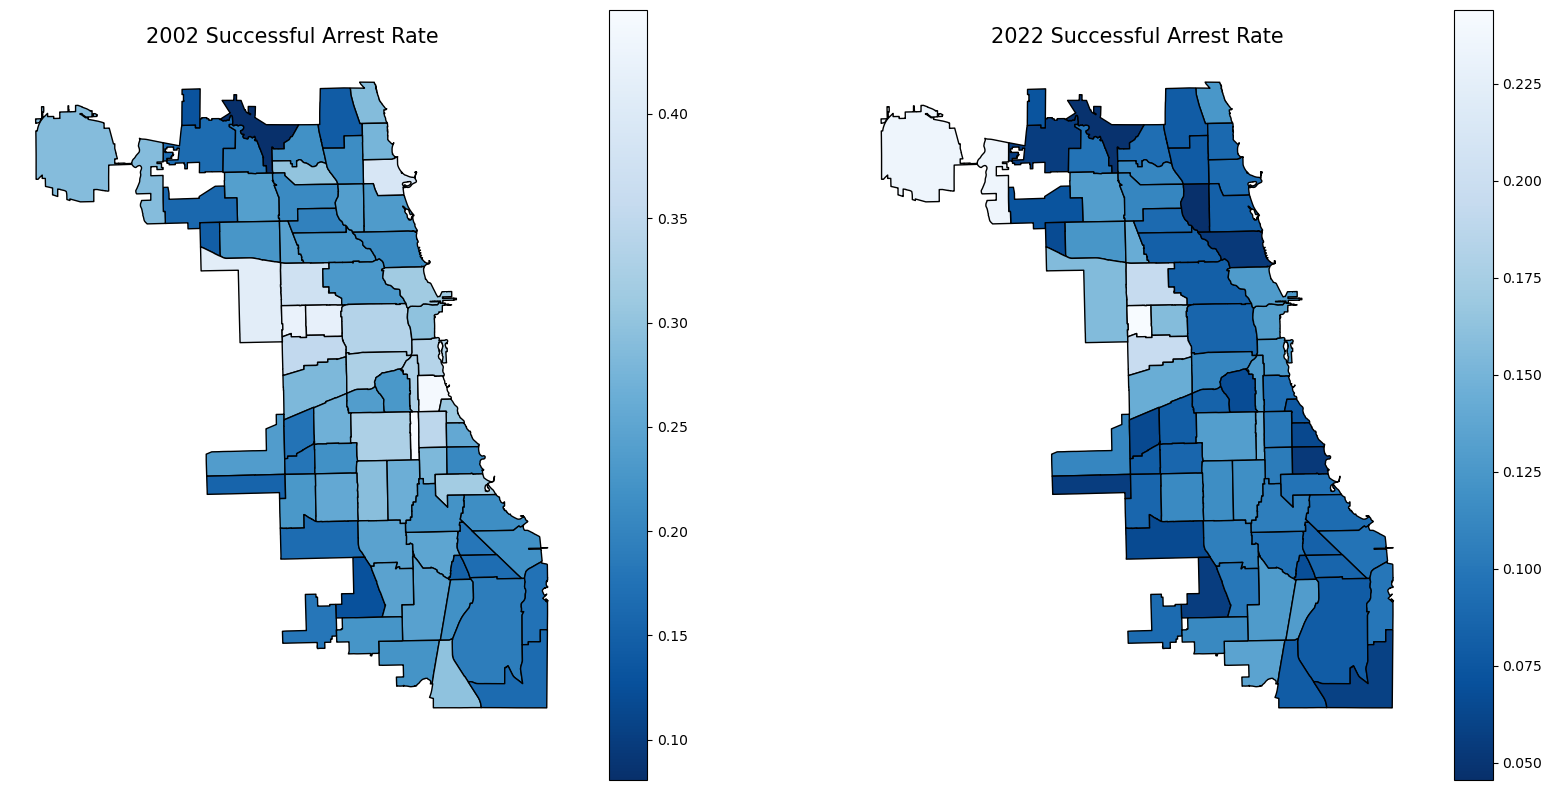

In [23]:
# Creating the plots
fig, axes = plt.subplots(1, 2, figsize = (20,10))

!
mer_2002.plot(column = "Successful Arrest Rate",
                  legend = True, ax = axes[0], 
                  cmap = "Blues_r", edgecolor = "black")

axes[0].set_title("2002 Successful Arrest Rate", fontsize = '15')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].set_yticks([])
axes[0].set_xticks([])

mer_2022.plot(column = "Successful Arrest Rate",
              legend = True, ax = axes[1],
              cmap = "Blues_r", edgecolor = "black")

axes[1].set_title("2022 Successful Arrest Rate", fontsize = '15')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].set_yticks([])
axes[1].set_xticks([])

The main idea we learn from this visualization is that nearly all communities suffer from a decrease in their successful arrest rate. This helps us infer that Chicago's surprisingly low rate is not being brought down by a few bad communities, but rather an effective decrease in the entirety of the city. With this in mind, we can now shift our focus to studying catalysts that alter the entire city of Chicago rather than a few communities. It is also important to note that one of the only areas to experience an increase in their successful arrest rate is the community in which the Chicago International Airport is located (top left of the map); this increase is likely because of a shift of police department focus to these areas to ensure safety of incoming tourists.

[]

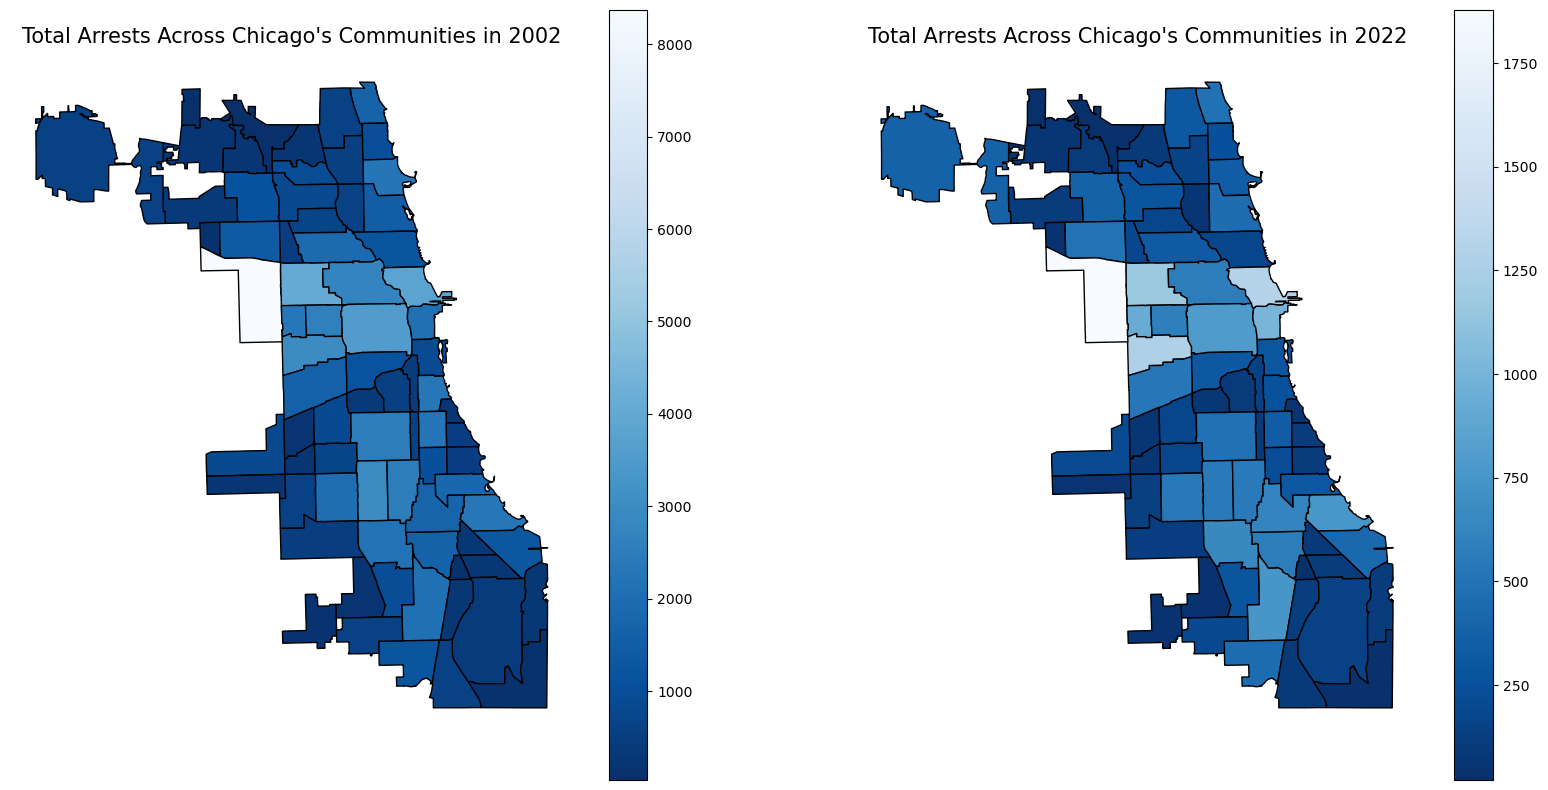

In [24]:
#Plotting a map showing the variation in total arrests over all communities 
fig, axes = plt.subplots(1, 2, figsize = (20,10))

mer_2002.plot(column = "Total Arrests",
                  legend = True, ax = axes[0], 
                  cmap = "Blues_r", edgecolor = "black")
axes[0].set_title("Total Arrests Across Chicago's Communities in 2002", fontsize = '15')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].set_yticks([])
axes[0].set_xticks([])


mer_2022.plot(column = "Total Arrests",
                  legend = True, ax = axes[1], 
                  cmap = "Blues_r", edgecolor = "black")
axes[1].set_title("Total Arrests Across Chicago's Communities in 2022" , fontsize = '15')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].set_yticks([])
axes[1].set_xticks([])

The above maps visualize the total arrests made in each community over the years 2002 and 2022, which cover a total of 20 years. The most important observation that can be made is the fact that the number of total arrests per community has decreased significantly over a period of only 20 years. The map really puts into context how rapid of a decline the successful arrest rate has taken in Chicago. Positively, however, we notice that in general, communities have held similar ranks relative to other communities, meaning that we are witnessing a general, and equal, decrease among all communities and not just a selected few.

[]

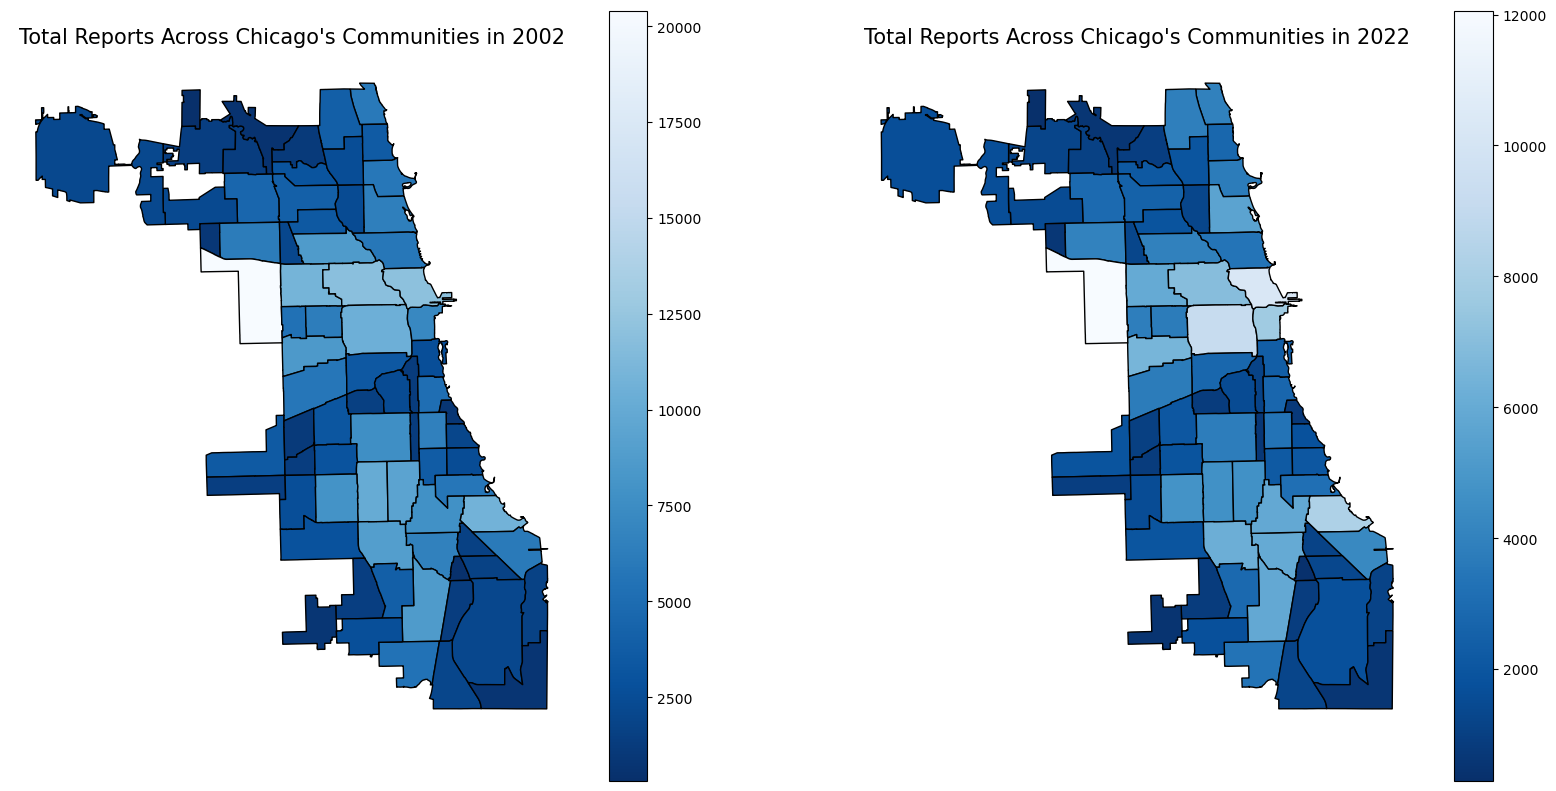

In [183]:
#Plotting a map showing the variation in total arrests over all communities 
fig, axes = plt.subplots(1, 2, figsize = (20,10))

mer_2002.plot(column = "Total Reports",
                  legend = True, ax = axes[0], 
                  cmap = "Blues_r", edgecolor = "black")
axes[0].set_title("Total Reports Across Chicago's Communities in 2002", fontsize = '15')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].set_yticks([])
axes[0].set_xticks([])


mer_2022.plot(column = "Total Reports",
                  legend = True, ax = axes[1], 
                  cmap = "Blues_r", edgecolor = "black")
axes[1].set_title("Total Reports Across Chicago's Communities in 2022" , fontsize = '15')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].set_yticks([])
axes[1].set_xticks([])

## Project Three

### 3.1 - Potential Data to Scrape

#### 3.1.1 - Safety Index

After conducting a thorough research process, I have found that the data that would best compliment my research project is a "Safety Index" that provides a safety score (ranging from 0 to 100) to each of the Chicago Communities. This data can be found at: https://www.veryapt.com/guides/safety/L664-chicago/. This dataset allows me to study the relationship between a community's safety index score and its successful arrest rate, a relationship that I believe would provide very insightful information regarding my research question of the determinants of the successful arrest rate in Chicago. 

The dataset would be merged with a newly created dataframe that contains information on each community area, separated by year; the dataset would include variables such as: community name, community number, total reports, total "violent" crimes, and the successful arrest rate, etc...In this case, the relationship would be studied using a linear regression, and could be used as a controlling variable during multiple linear regression analyses. The use of a safety index as a controlling variable would likely help the model's fit and allow it to create more accurate predictions.

#### 3.1.2 - Population and Geographic Metrics

Rather than webscraping the provided weather data, I have decided to instead scrape data regarding the population and area of each of the 77 communities in Chicago. This is because the weather data is completely unrelated to my research question, and although the population and geographic metrics of each community is not my preferred data, it will definitely allow me to conduct more useful research. Adding variables that allow me to calculate crime rate, and that can be used as controlling variables in a multiple linear regression analysis will come to be useful for my research question. The data can be found at: https://en.wikipedia.org/wiki/Community_areas_in_Chicago.

### 3.2 - Potential Challenges

#### 3.2.1 - Safety Index

As beneficial as the data would be to my results, I am unable to webscrape it due to the website's Terms of Services. Under Article 6i, "VeryApt" explicitly mentions that their ToS does not permit the use of Scrapers, or similar automated means, to access their website. This means that it is both unethical and illegal to attempt to recover the data table using Python's webscrapers. Although the table can easily be copied without the use of advanced software, the Project Guidelines do not allow for this. Additionally, the website does not have an API for me to gather data through it.

I have attempted to find similar data on other websites that allow for web scraping but was unable to.If I was able to directly scrape the site, I would only need to do it once and not over an extended period of time because the data is of the cross-sectional type. Based on the HTML code that I have observed, I believe that I have all the necessary skill set needed to scrape the table, but am unable to due to the above reason.

#### 3.2.2 - Population and Geographic Metrics

With the population and geographic metric data, I know that I have all the necessary skills needed to scrape this Wikipedia website as we have covered very similar examples in class. Similar to the safety index data, this information would likely need to be updated on an annual basis. Unfortunately, an issue with the data is that its metrics for communiyu-level population are based on 2020 only, meaning that I would only have accurate population data for that one year.

This, however, is not a big issue as I plan on taking the logarithm of the variable when conducting linear regressions in the following parts. By taking the logarithm of population, the year-by-year changes would hold less importance than they would otherwise.

### 3.3 - Scraping Data from a Website

In [25]:
web_url = "https://en.wikipedia.org/wiki/Community_areas_in_Chicago"
response = requests.get(web_url)
print('Status Code\n', response.status_code)

Status Code
 200


A '200' Status Code means that the website is available for webscraping. The following lines of code will show the process of obtaining the dataframe.

In [26]:
soup_object = BeautifulSoup(response.content)
str(soup_object)[:3000]

'<!DOCTYPE html>\n<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-language-alert-in-sidebar-enabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-enabled vector-feature-main-menu-pinned-disabled vector-feature-limited-width-enabled vector-feature-limited-width-content-enabled vector-feature-zebra-design-disabled" dir="ltr" lang="en">\n<head>\n<meta charset="utf-8"/>\n<title>Community areas in Chicago - Wikipedia</title>\n<script>document.documentElement.className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-language-alert-in-sidebar-enabled vector-feature-sticky-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-enabled vector-feature-main-menu-pinned-disabled vector-feature-limited-width-enabled vector-feature-limited-width-content-e

In [27]:
data_table = soup_object.find_all('table', 'wikitable sortable plainrowheaders mw-datatable')[0] #exctracting exact table from the wikipeedia site
str(data_table)[:2000]

'<table class="wikitable sortable plainrowheaders mw-datatable" style="text-align:right">\n<caption>Chicago community areas by number, population, and area<sup class="reference" id="cite_ref-City_basics_9-0"><a href="#cite_note-City_basics-9">[8]</a></sup>\n</caption>\n<tbody><tr>\n<th rowspan="2" scope="col">No.\n</th>\n<th rowspan="2" scope="col">Name\n</th>\n<th scope="col">Population\n</th>\n<th colspan="2" scope="col">Area<sup class="reference" id="cite_ref-CMAP_Area_10-0"><a href="#cite_note-CMAP_Area-10">[9]</a></sup>\n</th>\n<th colspan="2" scope="col">Density\n</th></tr>\n<tr>\n<th><span style="font-size:85%;"><style data-mw-deduplicate="TemplateStyles:r886047488">.mw-parser-output .nobold{font-weight:normal}</style><span class="nobold">(2020)<sup class="plainlinks noexcerpt noprint asof-tag update" style="display:none;"><a class="external text" href="https://en.wikipedia.org/w/index.php?title=Community_areas_in_Chicago&amp;action=edit">[update]</a></sup></span></span><sup cla

In [28]:
all_values = data_table.find_all('tr')
str(all_values)[:3000]

'[<tr>\n<th rowspan="2" scope="col">No.\n</th>\n<th rowspan="2" scope="col">Name\n</th>\n<th scope="col">Population\n</th>\n<th colspan="2" scope="col">Area<sup class="reference" id="cite_ref-CMAP_Area_10-0"><a href="#cite_note-CMAP_Area-10">[9]</a></sup>\n</th>\n<th colspan="2" scope="col">Density\n</th></tr>, <tr>\n<th><span style="font-size:85%;"><style data-mw-deduplicate="TemplateStyles:r886047488">.mw-parser-output .nobold{font-weight:normal}</style><span class="nobold">(2020)<sup class="plainlinks noexcerpt noprint asof-tag update" style="display:none;"><a class="external text" href="https://en.wikipedia.org/w/index.php?title=Community_areas_in_Chicago&amp;action=edit">[update]</a></sup></span></span><sup class="reference" id="cite_ref-CMAP_Population_11-0"><a href="#cite_note-CMAP_Population-11">[10]</a></sup>\n</th>\n<th><span style="font-size:85%;"><link href="mw-data:TemplateStyles:r886047488" rel="mw-deduplicated-inline-style"/><span class="nobold">(sq mi.)</span></span>\n<

In [29]:
wiki_comm = pd.DataFrame(columns = ['Community Area', 'Population', 'Area (sq. mi)',
                                    'Area (sq. km)', 'Density (sq. mi)', 'Density (sq. km)']) #defining the column names based 
ix = 0 
x=1
for row in all_values[2:79]: # writing a for-loop that places each variable under the desired column
    values = row.find_all('td') 
    num = x
    pop = values[1].text
    area_mi = values[2].text
    area_km = values[3].text
    den_mi = values[4].text
    den_km = values[5].text[:-1]
    
    wiki_comm.loc[ix] = [num, pop, area_mi, area_km, den_mi, den_km]
    ix += 1
    x += 1

In [30]:
wiki_comm.head()

,Community Area,Population,Area (sq. mi),Area (sq. km),Density (sq. mi),Density (sq. km)
0,1,"55,628",1.84,4.77,"30,232.61","11,672.81"
1,2,"77,122",3.53,9.14,"21,847.59","8,435.36"
2,3,"57,182",2.32,6.01,"24,647.41","9,516.37"
3,4,"40,494",2.56,6.63,"15,817.97","6,107.32"
4,5,"35,114",2.05,5.31,"17,128.78","6,613.42"


In [31]:
relevant_columns = ['Community Area', 'Population', 'Area (sq. mi)', 'Density (sq. mi)']
wiki_comm = wiki_comm[relevant_columns]
wiki_comm.head()

,Community Area,Population,Area (sq. mi),Density (sq. mi)
0,1,"55,628",1.84,"30,232.61"
1,2,"77,122",3.53,"21,847.59"
2,3,"57,182",2.32,"24,647.41"
3,4,"40,494",2.56,"15,817.97"
4,5,"35,114",2.05,"17,128.78"


### 3.4 - Merging the Scraped Dataset

In [32]:
merged_comm = pd.merge(grouped_comm, wiki_comm, on = 'Community Area', how = "outer")
merged_comm.head(10)

,Community Area,Year,Total Reports,Total Arrests,Successful Arrest Rate,Population,Area (sq. mi),Density (sq. mi)
0,1.0,2002,5899,1694,0.287167,"55,628",1.84,"30,232.61"
1,1.0,2003,7628,2324,0.304667,"55,628",1.84,"30,232.61"
2,1.0,2004,7587,2232,0.294187,"55,628",1.84,"30,232.61"
3,1.0,2005,7484,2547,0.340326,"55,628",1.84,"30,232.61"
4,1.0,2006,7155,2529,0.353459,"55,628",1.84,"30,232.61"
5,1.0,2007,6784,2302,0.339328,"55,628",1.84,"30,232.61"
6,1.0,2008,6388,1466,0.229493,"55,628",1.84,"30,232.61"
7,1.0,2009,5878,1854,0.315413,"55,628",1.84,"30,232.61"
8,1.0,2010,5571,1510,0.271046,"55,628",1.84,"30,232.61"
9,1.0,2011,5107,1448,0.283532,"55,628",1.84,"30,232.61"


In [33]:
merged_comm.shape

(1617, 8)

Given the above output, I can confirm that the merging of the scraped data to my pre-existing dataset has left me with 1,617 observations. This is a suffucient amount of observations for the regression analyses that will be carried out later in the study.

### 3.5 - Visualizing the Scraped Dataset

In [34]:
# creating a dataset with the crime variables and geospatial data for mapping
merged_map = chicago_districts_map.merge(merged_comm, on = "Community Area", how = 'outer')

In [35]:
# Removing the commas from values in Population
def remove_commas(s):
    return s.replace(",", "")
merged_map['n_Population'] = merged_map['Population'].apply(remove_commas)
merged_map['n_Population'] = merged_map['n_Population'].astype(int)

In [36]:
merged_map.head()

,area,area_num_1,area_numbe,comarea,comarea_id,community,perimeter,shape_area,shape_len,geometry,Community Area,Year,Total Reports,Total Arrests,Successful Arrest Rate,Population,Area (sq. mi),Density (sq. mi),n_Population
0,0.0,1,1,0.0,0.0,ROGERS PARK,0.0,5.125990e+07,34052.397576,"POLYGON ((-87.65456 41.99817, -87.65574 41.998...",1,2002,5899,1694,0.287167,"55,628",1.84,"30,232.61",55628
1,0.0,1,1,0.0,0.0,ROGERS PARK,0.0,5.125990e+07,34052.397576,"POLYGON ((-87.65456 41.99817, -87.65574 41.998...",1,2003,7628,2324,0.304667,"55,628",1.84,"30,232.61",55628
2,0.0,1,1,0.0,0.0,ROGERS PARK,0.0,5.125990e+07,34052.397576,"POLYGON ((-87.65456 41.99817, -87.65574 41.998...",1,2004,7587,2232,0.294187,"55,628",1.84,"30,232.61",55628
3,0.0,1,1,0.0,0.0,ROGERS PARK,0.0,5.125990e+07,34052.397576,"POLYGON ((-87.65456 41.99817, -87.65574 41.998...",1,2005,7484,2547,0.340326,"55,628",1.84,"30,232.61",55628
4,0.0,1,1,0.0,0.0,ROGERS PARK,0.0,5.125990e+07,34052.397576,"POLYGON ((-87.65456 41.99817, -87.65574 41.998...",1,2006,7155,2529,0.353459,"55,628",1.84,"30,232.61",55628


([], [])

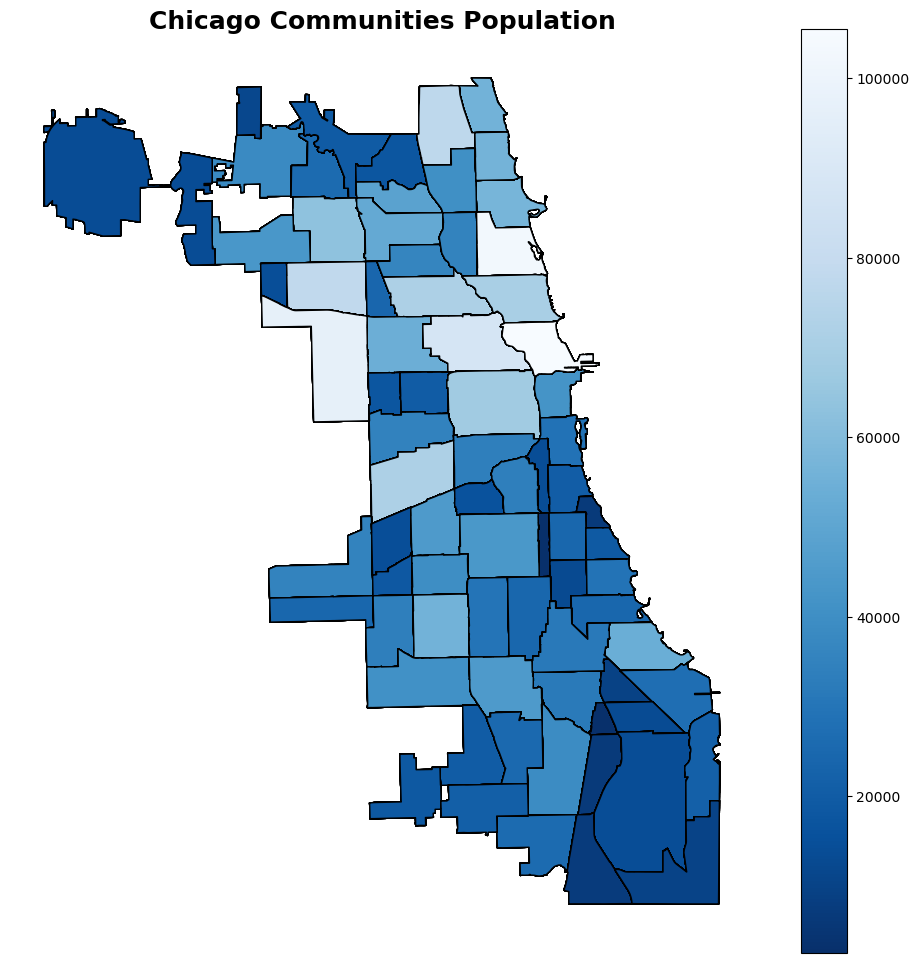

In [37]:
fig, axes = plt.subplots(1, 1, figsize = (12,12))

merged_map.plot(column = "n_Population",
                  legend = True, ax = axes, 
                  cmap = "Blues_r", edgecolor = "black")
plt.title("Chicago Communities Population", fontsize = 18, fontweight = "bold")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

This map allows us to understand that the population of Chicago is quite evenly spread across the bottom of the city, but comes to be more clustered as we approach the top. Towards the upper part of the map, we see many more population dense communities than on the bottom. Seeing as we see this relationship between the different parts of Chicago, we can infer that the population of each community could be related to its succcessful arrest rate.

In [38]:
# Removing the commas from values in Density (Sq. Mi)
def remove_commas(s):
    return s.replace(",", "")
merged_map['n_Density (sq. mi)'] = merged_map['Density (sq. mi)'].apply(remove_commas)
merged_map['n_Density (sq. mi)'] = merged_map['n_Density (sq. mi)'].astype(float)

([], [])

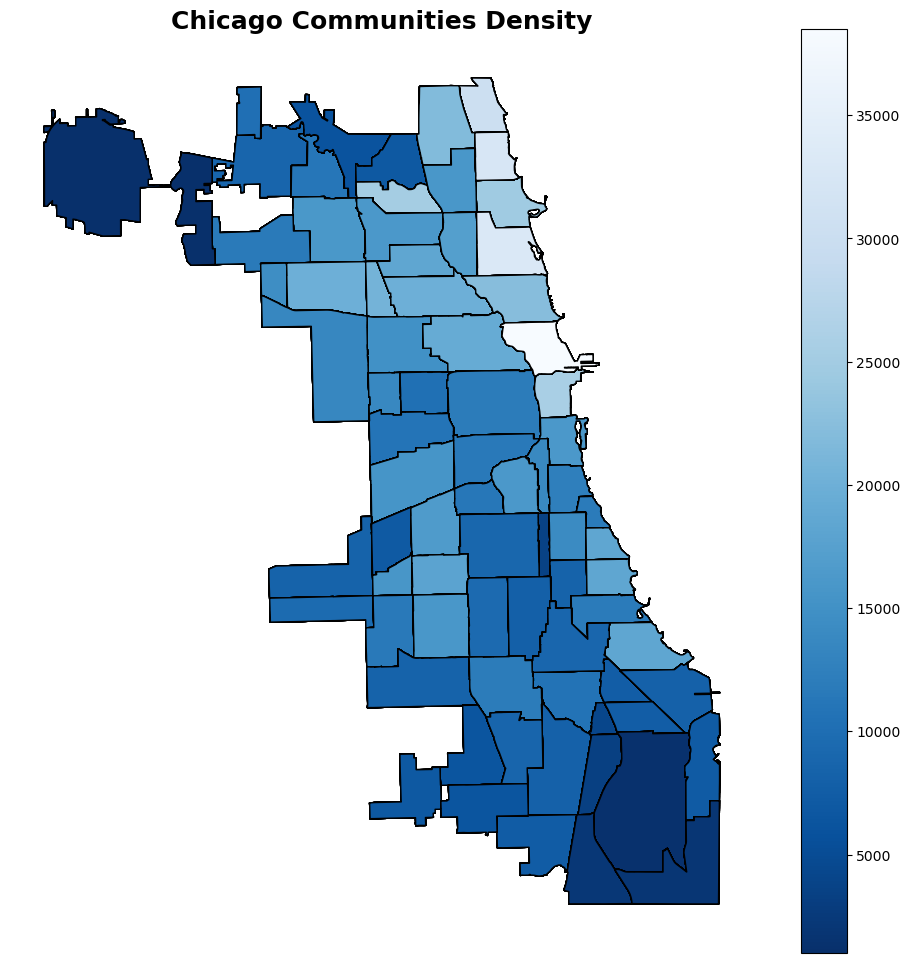

In [39]:
fig, axes = plt.subplots(1, 1, figsize = (12,12))

merged_map.plot(column = "n_Density (sq. mi)",
                  legend = True, ax = axes, 
                  cmap = "Blues_r", edgecolor = "black")
plt.title("Chicago Communities Density", fontsize = 18, fontweight = "bold")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

Here, we see that communities along the right coast of Chicago are far more dense than any other area in the entire city. Furthermore, we see that the bottom right, and top left parts of the map are the least dense communities, with the center part of the city being relatively evenly spread out. Due to this observed relationship, it is likely that community density has an associating role in a community's SAR.

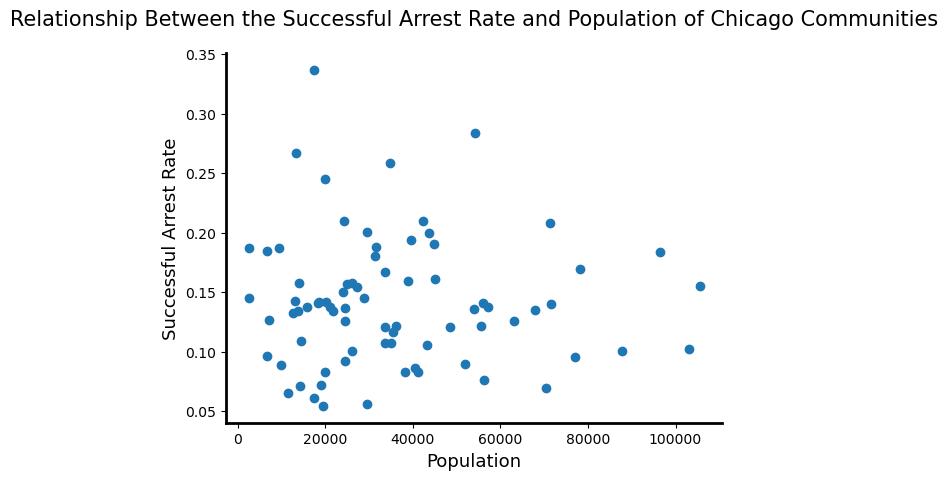

In [40]:
sort = merged_map.sort_values('n_Population')
sort = sort[sort['Year'] == 2020]
plt.scatter(sort["n_Population"], sort["Successful Arrest Rate"])
plt.xticks()
plt.xlabel("Population", size = 13)
plt.ylabel("Successful Arrest Rate", size =13)
plt.title("Relationship Between the Successful Arrest Rate and Population of Chicago Communities", size = 15, pad = 20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.show()

In direct contradiction to the above statement, this scatter plot allows us to visualize the relationship between a community's population and its successful arrest rate. Surprisingly, there is neither a positive not negative relationship between the two variables. In order to completely rule out the possibility of the population having an influence on a community's succcesful arrest rate, a multiple linear regression analysis must be conducted holding the population fixed. Seeing as Project 3 focuses on obtaining and visulaizing additional data, the analysis will be performed as part of the Final Project.

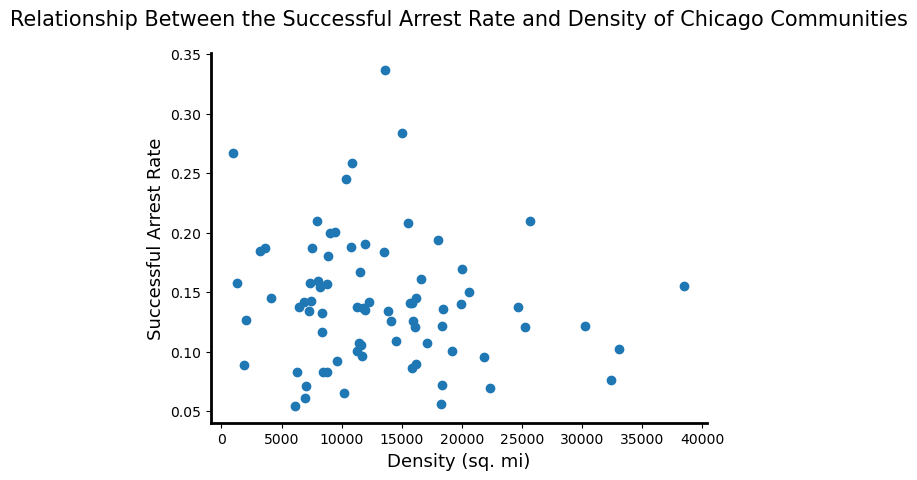

In [41]:
sort = merged_map.sort_values('n_Density (sq. mi)')
sort = sort[sort['Year'] == 2020]
plt.scatter(sort["n_Density (sq. mi)"], sort["Successful Arrest Rate"])
plt.xticks()
plt.xlabel("Density (sq. mi)", size = 13)
plt.ylabel("Successful Arrest Rate", size = 13)
plt.title("Relationship Between the Successful Arrest Rate and Density of Chicago Communities", size = 15, pad = 20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.show()

Similar to the above scatterplot, we see neither a negative nor positive relationship between a community's successful arrest rate and its density. All points are quite evenly spread across table, implying that Density would most likely prove to be unrelated to the successful arrest rate of a community and would not be beneficial in a multiple linear regression analysis.

### 3.6 - Adding A New Dataset

After looking through the suggested datasets on Quercus, I had to do additional research to attempt to find additional data that supports my research question and provides me with additional variables that could help account for a community's successful arrest rate. With this additional research, I was able to find three supplementary datasets that contained additional socioeconomic variables for each of the 77 Chicago Community Areas.

The first dataset can be found at: https://data.cityofchicago.org/Health-Human-Services/Census-Data-Selected-socioeconomic-indicators-in-C/kn9c-c2s2 . It contains socioeconomic indicators such as per capita income, a hardship index, percent of households below the poverty line, among others. 

The second dataset can be found at: https://data.cityofchicago.org/Health-Human-Services/Public-Health-Statistics-Selected-public-health-in/iqnk-2tcu . It contains information on health variables of the communities, such as the birth rate, and socioeconomic variables including unemployment and percent of population with no high school diploma.

The third dataset can be found at: https://data.cityofchicago.org/Health-Human-Services/Public-Health-Statistics-Life-Expectancy-By-Commun/qjr3-bm53 . It contains a variable for the average life expectancy of each community in 2010.

The main issue with these variables is that they are all measured throughout different, static, periods of time. This means that the socioeconomic variables collected are not representative of the entire period being studied in this paper. This is one of the limitations of my study, and in order to produce more accurate results, they must be overcome. However, with these extra datasets, I have access to more explanatory variables that could be associated with the observed decrease in the SAR.

Note: the data was merged, cleaned, and introduced at the beginning of this notebook under 'final_data'


### 3.7 - Visualizing the New Dataset

In [53]:
desc = pd.DataFrame(final_data.describe().round(2))
desc = desc.drop('Community Area', axis = 1)
desc = desc.drop('Year', axis = 1)
desc

,Total Reports,Total Arrests,Successful Arrest Rate,Area (Sq. Mi),Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Per Capita Income,Hardship Index,Birth Rate,No High School Diploma,Unemployment,2010 Life Expectancy,const,Population,Density (Sq. Mi),ln_Total_Arrests,ln_Total_Reports,ln_Percapita_Income,ln_Population
count,1617.00,1617.00,1617.00,1617.00,1617.00,1617.00,1617.00,1617.00,1617.00,1617.00,1617.00,1617.00,1617.00,1617.0,1617.00,1617.00,1617.00,1617.00,1617.00,1617.00
mean,4334.41,1128.07,0.22,3.00,21.77,15.37,20.34,25563.17,49.51,15.70,21.60,13.30,77.60,1.0,35667.38,13246.02,6.38,7.99,10.01,10.24
std,3900.74,1420.41,0.09,1.96,11.46,7.50,11.75,15198.17,28.51,3.51,12.28,6.99,4.06,0.0,23528.51,7383.54,1.21,0.91,0.50,0.75
min,234.00,11.00,0.04,0.58,3.30,4.70,2.50,8201.00,1.00,9.40,2.90,4.20,68.80,1.0,2527.00,1005.85,2.40,5.46,9.01,7.83
25%,1530.00,268.00,0.15,1.78,13.20,9.20,11.80,15754.00,25.00,12.90,13.40,7.80,74.40,1.0,18628.00,8173.65,5.59,7.33,9.66,9.83
50%,2962.00,581.00,0.21,2.86,18.90,13.90,18.50,21323.00,50.00,15.70,18.50,11.50,79.50,1.0,29647.00,11722.41,6.36,7.99,9.97,10.30
75%,6178.00,1540.00,0.27,3.55,29.20,20.00,26.60,28887.00,74.00,18.50,29.40,17.40,80.50,1.0,45053.00,16563.60,7.34,8.73,10.27,10.72
max,30627.00,13423.00,0.53,13.34,56.50,35.90,54.80,88669.00,98.00,22.40,58.70,40.00,85.20,1.0,105481.00,38496.72,9.50,10.33,11.39,11.57


Through the above figure, one can instantly see the increased number of socioeconomic variables that can be used to explore their relationship with the SAR. The data, similar to before, contains a lot of variation across the different communities and throughout the twenty years, and this is most specifically seen through the relatively large standard deviations on each variable, which also points to a right-skew of the data.

[]

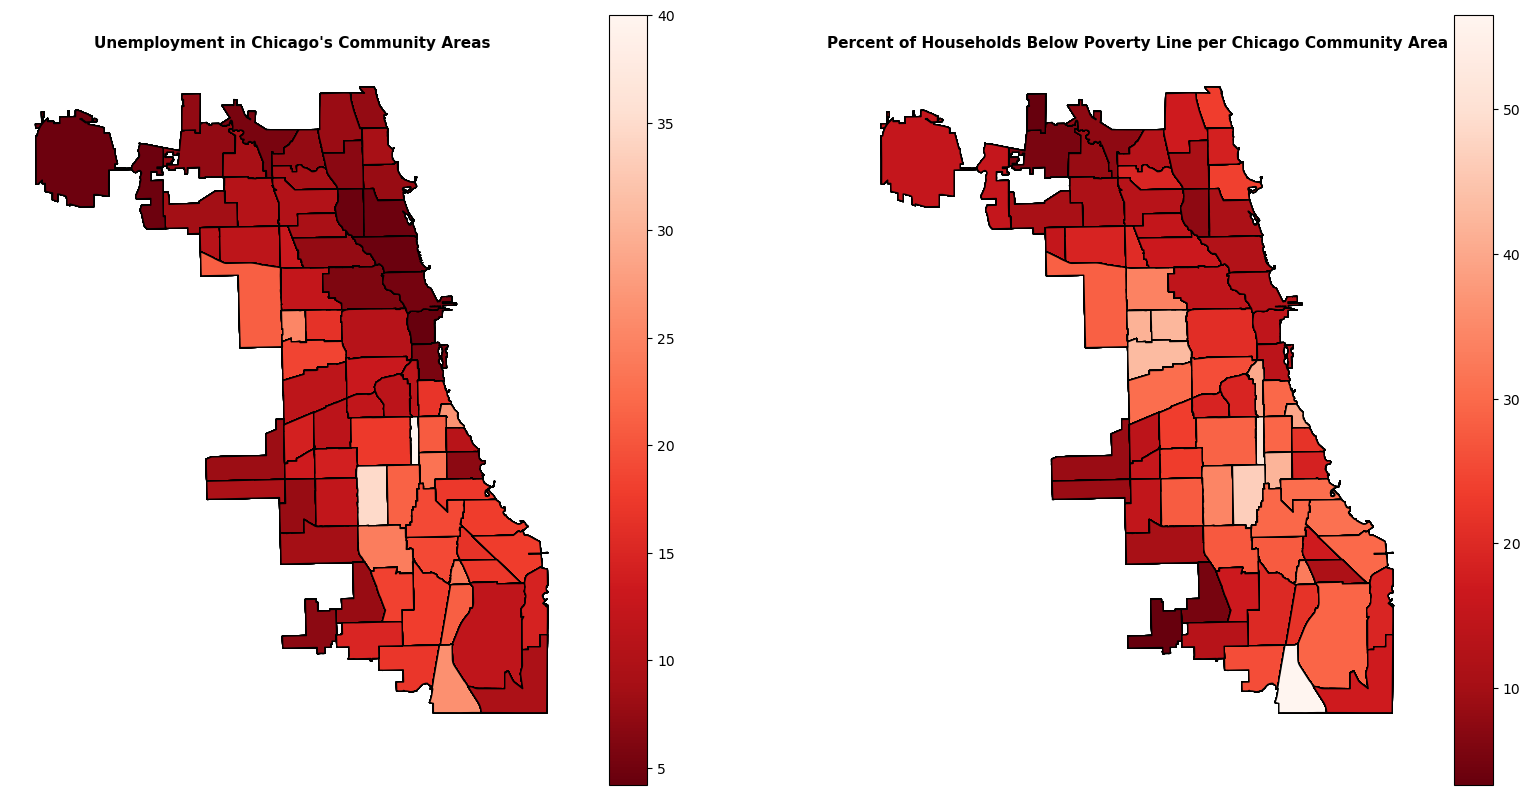

In [54]:
unemp = final_data[['Community Area', 'Unemployment']]
chi_unemp = chicago_districts_map.merge(unemp, on = 'Community Area')

fig, axes = plt.subplots(1, 2, figsize = (20, 10))

chi_unemp.plot(column = "Unemployment",
                  legend = True, ax = axes[0], 
                  cmap = "Reds_r", edgecolor = "black")
axes[0].set_title("Unemployment in Chicago's Community Areas", fontsize = '11', fontweight = 'bold')
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].set_yticks([])
axes[0].set_xticks([])




pov = final_data[['Community Area', 'Percent Households Below Poverty']]
chi_pov = chicago_districts_map.merge(pov, on = 'Community Area')

chi_pov.plot(column = "Percent Households Below Poverty",
                  legend = True, ax = axes[1], 
                  cmap = "Reds_r", edgecolor = "black")

axes[1].set_title("Percent of Households Below Poverty Line per Chicago Community Area" , fontsize = '11', fontweight = 'bold')
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].set_yticks([])
axes[1].set_xticks([])

Through the above graphs, we can see that there does not appear to be that strong of a relationship between unemployment in a community and the percent of households below the poverty line. This is, still, not opposing of the general belief that the socioeconomic variables are directly proportional because we see that commmunities with higher unemployments generally have a higher percent of households below the poverty line.

Additionally, the graph allows us to visualize two variables that are likely to be related to the SAR and its decrease over the years. Unfortunately, the data collected is not varied by year, meaning that it will be less effective in terms of finding relationships between the variables and the change in SAR. However, because of the fact that the variables are good measures of the ecomomic conditions of a community, their high correlations with the SAR would still allow for significant findings.

([], [])

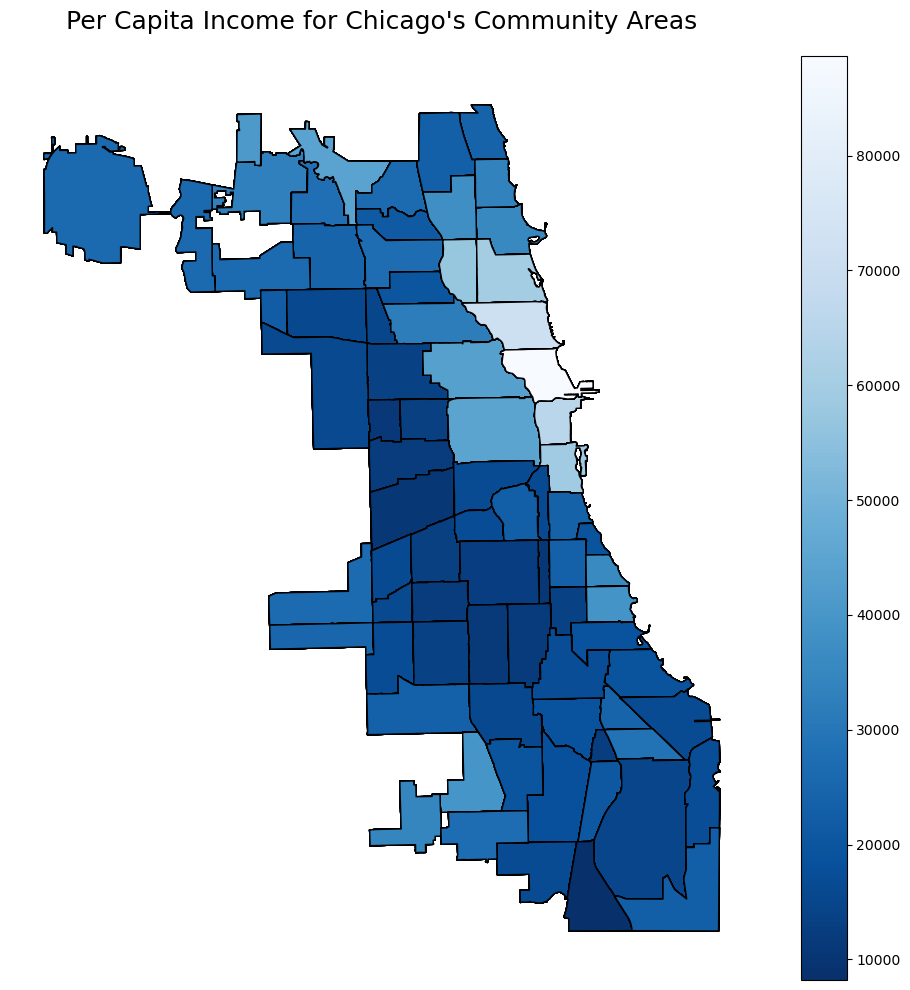

In [58]:
inc = final_data[['Community Area', 'Per Capita Income']]
chi_inc = chicago_districts_map.merge(inc, on = 'Community Area')

fig, axes = plt.subplots(1, 1, figsize = (12,12))

chi_inc.plot(column = "Per Capita Income",
                  legend = True, ax = axes, 
                  cmap = "Blues_r", edgecolor = "black")
plt.title("Per Capita Income for Chicago's Community Areas", fontsize = 18, pad = 25)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])

From the above graph, we can tell that there does not seem to be an apparent trend, or clustering, of per capita income in Chicago's Community Areas. However, an important detail that can be interpreted is that there is a relatively large range of values across the 77 communities, stretching between 10,000 and 80,000 dollars.

Intuitively, areas with lower per capita incomes are much more likely to be associated with a higher number of crimes, and might therefore also be related to the SAR of a community. Because of this, the large variation in per capita income will come to be useful in exploring its association with the successful arrest rate of communities.

## Final Project

### 4.1 - OLS Regressions

#### 4.1.1 - Preparing the Data

Seeing as one of the main goals of regression analysis is to be able to clearly interpret the results clearly, for this part of the study the SAR will be measured on a 100-point scale, with 100 being the highest possible SAR (100%), and 0 being the lowest possible (0%). By doing this, the regression output tables become clearer to understand for the reader and the written interpretations will make more intuitive sense to the general reader.

In [154]:
final_data = pd.read_csv('FinalData.csv')
final_data['const'] = 1 # creating a constant variable to get intercept with regressions
newnames = {'Per Capita Income ': 'Per Capita Income', 'Population': 'population', 'Density (Sq. Mi)': 'density (Sq. Mi)', 'Successful Arrest Rate': 'successful arrest rate'} # renaming variables
final_data = final_data.rename(columns = newnames)

In [155]:
def remove_commas(s): #creating a function that helps turn numerical variables saved as strings into floats
    return s.replace(",", "")

final_data['Population'] = (final_data['population']).apply(remove_commas)
final_data["Density (Sq. Mi)"] = final_data['density (Sq. Mi)'].apply(remove_commas)
final_data['Successful Arrest Rate'] = (final_data['successful arrest rate'] * 100)
# Transforming the variables into floats
final_data['Population'] = final_data['Population'].astype(float)
final_data["Density (Sq. Mi)"] = final_data["Density (Sq. Mi)"].astype(float)

In [156]:
# creating new logarithm variables in the dataset based on pre-existing variables
final_data['ln_Total_Arrests'] = np.log(final_data['Total Arrests'])
final_data['ln_Total_Reports'] = np.log(final_data['Total Reports'])
final_data['ln_Percapita_Income'] = np.log(final_data['Per Capita Income'])
final_data['ln_Population'] = np.log(final_data['Population'])

# dropping uncleaned versions of variables
final_data = final_data.drop('population', axis = 1)
final_data = final_data.drop('density (Sq. Mi)', axis = 1)
final_data = final_data.drop('successful arrest rate', axis = 1)

final_data.head()

,Community Area,Year,Total Reports,Total Arrests,Area (Sq. Mi),Community Area Name,Percent Households Below Poverty,Percent Aged 16+ Unemployed,Percent Aged 25+ Without High School Diploma,Per Capita Income,...,Unemployment,2010 Life Expectancy,const,Population,Density (Sq. Mi),Successful Arrest Rate,ln_Total_Arrests,ln_Total_Reports,ln_Percapita_Income,ln_Population
0,1.0,2002,5899,1694,1.84,Rogers Park,23.6,8.7,18.2,23939,...,7.5,77.3,1,55628.0,30232.61,28.716732,7.434848,8.682538,10.083264,10.926442
1,1.0,2003,7628,2324,1.84,Rogers Park,23.6,8.7,18.2,23939,...,7.5,77.3,1,55628.0,30232.61,30.466702,7.751045,8.939581,10.083264,10.926442
2,1.0,2004,7587,2232,1.84,Rogers Park,23.6,8.7,18.2,23939,...,7.5,77.3,1,55628.0,30232.61,29.418743,7.710653,8.934192,10.083264,10.926442
3,1.0,2005,7484,2547,1.84,Rogers Park,23.6,8.7,18.2,23939,...,7.5,77.3,1,55628.0,30232.61,34.032603,7.842671,8.920523,10.083264,10.926442
4,1.0,2006,7155,2529,1.84,Rogers Park,23.6,8.7,18.2,23939,...,7.5,77.3,1,55628.0,30232.61,35.345912,7.835579,8.875567,10.083264,10.926442


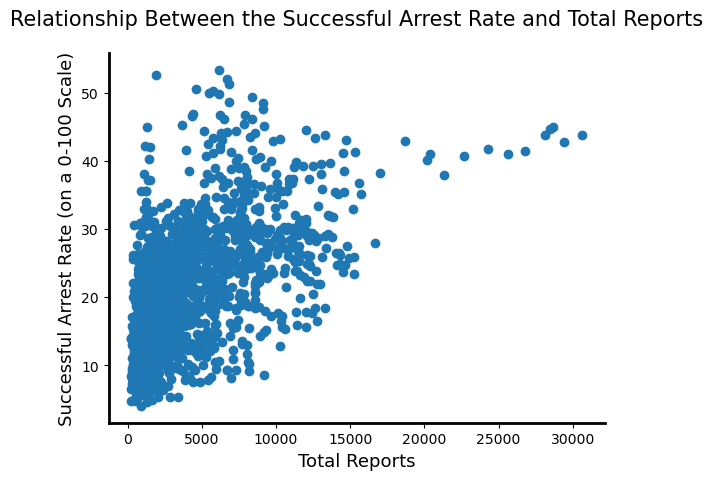

In [162]:
sort = final_data.sort_values('Total Reports')
plt.scatter(sort["Total Reports"], sort["Successful Arrest Rate"])
plt.xlabel("Total Reports", size = 13)
plt.ylabel("Successful Arrest Rate (on a 0-100 Scale)", size = 13)
plt.title("Relationship Between the Successful Arrest Rate and Total Reports", size = 15, pad = 20)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.show()

The above scatterplot shows a logarithmic relationship between Total Reports and the Successful Arrest Rate, where each observation is a community area in a year between 2002 and 2022. This is most likely because the unit of Total Reports is much greater than that of the SAR, therefore, in order to study any linear relationship between the variables, we must apply the natural logarithm to the value of Total Reports.

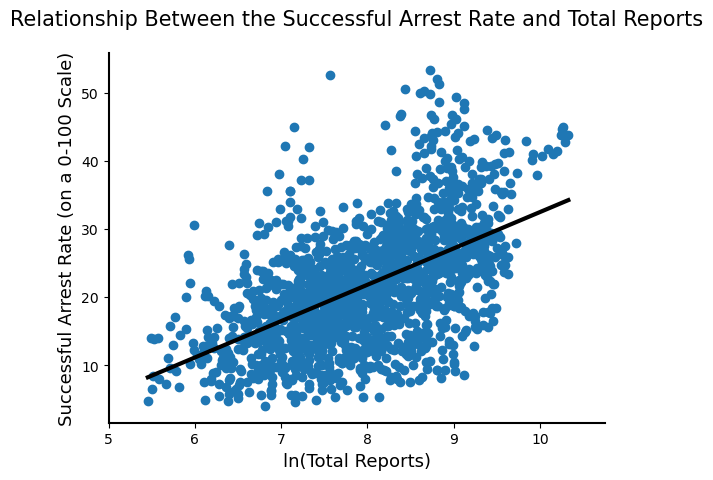

In [161]:
x = final_data['ln_Total_Reports']
y = final_data["Successful Arrest Rate"]

fig, ax = plt.subplots()
ax.scatter(x, y)

# Fit a linear trend line
ax.plot(np.unique(x),
         np.poly1d(np.polyfit(x, y, 1))(np.unique(x)),
         color='black', linewidth = 3)

ax.set_xlim([5,10.75])
ax.set_xlabel('ln(Total Reports)', size = 13)
ax.set_ylabel('Successful Arrest Rate (on a 0-100 Scale)', size = 13)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)
plt.title("Relationship Between the Successful Arrest Rate and Total Reports", size = 15, pad = 20)
plt.show()

After taking the logarithm of Total Reports, the linear relationship between the two variables is now clearer. However, the large amount of scatter about the OLS line means that the single regression model is most likely not goint to yield accurate results. With this in mind, the following tables are regression models, including both single and multiple regressions, that are used to explore the variables associated with the SAR.

#### 4.1.2 - The Intuition Behind Variable Choices

As mentioned previously, the paper's aim is to study the relationship between socioeconomic variables, such as the per capita income and unemployment rate, and the successful arrest rate of a commmunity over time. From the original dataset which included only information on the number of crime reports, arrests, and the SAR of each community per year, I was able to gather many more variables that properly explain the economic status of each community. 

#### 4.1.3 - The Regressions

In [207]:
# Create lists of variables to be used in each regression
X1 = ['const', 'ln_Total_Reports']
X2 = ['const', 'ln_Total_Arrests']
X3 = ['ln_Population', 'ln_Total_Arrests', 'ln_Total_Reports','const']
# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(final_data['Successful Arrest Rate'], final_data[X1], missing='drop').fit()
reg2 = sm.OLS(final_data['Successful Arrest Rate'], final_data[X2], missing='drop').fit()
reg3 = sm.OLS(final_data['Successful Arrest Rate'], final_data[X3], missing='drop').fit()

In [209]:
# Does not appear in HTML output, so results are printed in the code cells below this
stargazer = Stargazer([reg1, reg2, reg3])
stargazer.covariate_order(['ln_Total_Arrests', 'ln_Total_Reports', 'ln_Population', 'const'])
stargazer.rename_covariates({'ln_Total_Arrests': 'Total Arrests', 'ln_Total_Reports': 'Total Reports', 'ln_Population': 'Population', 'const': 'Constant'})
stargazer.custom_columns(['Model 1', 'Model 2', 'Model 3'], [1, 1, 1])

HTML(stargazer.render_html())
# print(stargazer.render_latex())

In [84]:
print(reg1.summary())

                              OLS Regression Results                              
Dep. Variable:     Successful Arrest Rate   R-squared:                       0.303
Model:                                OLS   Adj. R-squared:                  0.303
Method:                     Least Squares   F-statistic:                     702.5
Date:                    Sat, 15 Apr 2023   Prob (F-statistic):          7.90e-129
Time:                            09:31:03   Log-Likelihood:                 1926.2
No. Observations:                    1617   AIC:                            -3848.
Df Residuals:                        1615   BIC:                            -3838.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


The first mode is a simple linear regression between the Total Reports and SAR; this model is relatively ineffective as only 30% of the variation in the SAR is explained by variations in the total number of arrests. Moreover, we see a positive association between the total number of reports and the SAR, which is unexpected. One would believe that the greater the number of reports, the lower the proportion of reports with an arrest, but the model suggests otherwise.

In [85]:
print(reg2.summary())

                              OLS Regression Results                              
Dep. Variable:     Successful Arrest Rate   R-squared:                       0.585
Model:                                OLS   Adj. R-squared:                  0.585
Method:                     Least Squares   F-statistic:                     2281.
Date:                    Sat, 15 Apr 2023   Prob (F-statistic):          4.00e-311
Time:                            09:31:04   Log-Likelihood:                 2346.2
No. Observations:                    1617   AIC:                            -4688.
Df Residuals:                        1615   BIC:                            -4678.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


The second model is a simple linear regression between Total Arrests and the SAR. This model, similar to the first, is rather ineffective as only 59% of the variation in the SAR is explained by variation in the total number of arrests. Furthermore, the relationship between the SAR and the total number of arrests demonstrated by the model is intuitive: the greater the total number of arrests made, the greater the SAR. 

In [86]:
print(reg3.summary())

                              OLS Regression Results                              
Dep. Variable:     Successful Arrest Rate   R-squared:                       0.925
Model:                                OLS   Adj. R-squared:                  0.924
Method:                     Least Squares   F-statistic:                     4938.
Date:                    Sat, 15 Apr 2023   Prob (F-statistic):               0.00
Time:                            09:31:05   Log-Likelihood:                 3723.6
No. Observations:                    1617   AIC:                            -7437.
Df Residuals:                        1612   BIC:                            -7410.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

The third model is by far the best of the three. This is a multiple linear regression model with three dependent variables: total arrests, total reports, and population. Approximately 92.5% of the variation in SAR is explained by the variation between the three variables, meaning that the model is a good predictor of the successful arrest rate when given values of the total number of reports, arrests and the population. The following is the formal representation of the model:

$${SAR}_i = 51.358 + 18.023*{Total Arrests}_i - 16.88*{Total Reports}_i - 0.941{Population}_i$$


The intercept, in this case, has no interpretation as it outside the scope of the model. The regression suggests that, when holding fixed the total number of reports and population, a 10% increase in total arrests is associated with, on average, a 1.8 percentage point increase in the SAR. Furthermore, when holding fixed the total number of arrests and the population, a 10% increase in total reports is associated with, on average, a 1.7 percentage point decrease in the SAR. Lastly, the model suggests that, when holding fixed the total number of reports and arrests, a 10% increase in population is associated with, on average, 0.09 percentage point decrease in the SAR, which is a relatively small change. Overall, the model is relatively significant considering the high statistical significance of each slope coefficient and the moderate change in each variable when holding the others fixed. It is important to note that a 1 percentage point increase in this context could equate to thousands of more reports having an arrest.

Moreover, we can see that Model 3 follows the previously outlined intuitive relationship between total reports and the SAR, meaning that controlling for total arrests and population allowed for the model to self-correct. This is important as it implies that the model makes sense and is better suited for our predictions.


In [225]:
# Create lists of variables to be used in each regression
X1 = ['const', 'Unemployment', 'No High School Diploma', 'Birth Rate', 'Percent Households Below Poverty']
X2 = ['const', 'Unemployment', 'No High School Diploma', 'Percent Households Below Poverty', '2010 Life Expectancy', 'Birth Rate', 'Hardship Index']
X3 = ['const','ln_Total_Reports', 'ln_Total_Arrests', 'ln_Population', 'ln_Percapita_Income', 'Unemployment', 'Hardship Index']
X4 = ['const','ln_Total_Reports', 'ln_Total_Arrests', 'ln_Population', 'ln_Percapita_Income', 'Unemployment', 'Birth Rate', 'No High School Diploma', 'Percent Households Below Poverty']

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(final_data['Successful Arrest Rate'], final_data[X1], missing='drop').fit()
reg2 = sm.OLS(final_data['Successful Arrest Rate'], final_data[X2], missing='drop').fit()
reg3 = sm.OLS(final_data['Successful Arrest Rate'], final_data[X3], missing='drop').fit()
reg4 = sm.OLS(final_data['Successful Arrest Rate'], final_data[X4], missing='drop').fit()

In [226]:
# Does not appear in HTML output, so results are printed in the code cells below this
stargazer = Stargazer([reg1, reg2, reg3, reg4])
stargazer.covariate_order(['ln_Total_Arrests', 'ln_Total_Reports', 'ln_Population', 'ln_Percapita_Income', 'Unemployment', 'Birth Rate', 'No High School Diploma', 'Percent Households Below Poverty','const'])
stargazer.rename_covariates({'ln_Total_Arrests': 'Total Arrests', 'ln_Total_Reports': 'Total Reports', 'ln_Population': 'Population', 'const': 'Constant', 'ln_Percapita_Income': 'Per Capita Income'})
stargazer.custom_columns(['Model 4', 'Model 5', 'Model 6', 'Model 7'], [1,1,1,1])

HTML(stargazer.render_html())
# print(stargazer.render_latex())

In [217]:
print(reg1.summary())

                              OLS Regression Results                              
Dep. Variable:     Successful Arrest Rate   R-squared:                       0.269
Model:                                OLS   Adj. R-squared:                  0.267
Method:                     Least Squares   F-statistic:                     148.2
Date:                    Sun, 16 Apr 2023   Prob (F-statistic):          5.24e-108
Time:                            22:42:10   Log-Likelihood:                -5559.1
No. Observations:                    1617   AIC:                         1.113e+04
Df Residuals:                        1612   BIC:                         1.116e+04
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [218]:
print(reg2.summary())

                              OLS Regression Results                              
Dep. Variable:     Successful Arrest Rate   R-squared:                       0.295
Model:                                OLS   Adj. R-squared:                  0.292
Method:                     Least Squares   F-statistic:                     112.1
Date:                    Sun, 16 Apr 2023   Prob (F-statistic):          2.79e-118
Time:                            22:42:10   Log-Likelihood:                -5530.2
No. Observations:                    1617   AIC:                         1.107e+04
Df Residuals:                        1610   BIC:                         1.111e+04
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [219]:
print(reg3.summary())

                              OLS Regression Results                              
Dep. Variable:     Successful Arrest Rate   R-squared:                       0.926
Model:                                OLS   Adj. R-squared:                  0.926
Method:                     Least Squares   F-statistic:                     3353.
Date:                    Sun, 16 Apr 2023   Prob (F-statistic):               0.00
Time:                            22:42:10   Log-Likelihood:                -3708.3
No. Observations:                    1617   AIC:                             7431.
Df Residuals:                        1610   BIC:                             7468.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [220]:
print(reg4.summary())

                              OLS Regression Results                              
Dep. Variable:     Successful Arrest Rate   R-squared:                       0.927
Model:                                OLS   Adj. R-squared:                  0.927
Method:                     Least Squares   F-statistic:                     2570.
Date:                    Sun, 16 Apr 2023   Prob (F-statistic):               0.00
Time:                            22:42:11   Log-Likelihood:                -3691.2
No. Observations:                    1617   AIC:                             7400.
Df Residuals:                        1608   BIC:                             7449.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

It is clear to see that the two models that use only socioeconomic factors, shown in columns (1) and (2), are largely ineffective, with less than 30% of the variation in the SAR being explained by variation in the dependent variables. However, the third and fourth models which include crime data do a much better job, with approximately 93% of the variation in the SAR being explained by variation in the dependent variables.

With this in mind, the model 3 of Regression table 1 is preferred over models 6 and 7 in Regression Table 2. This is because of the large amount of variables used in the last two models. The number of variables in the last two models is an issue because it poses the large risk of overfitting. Overfitting occurs when the model retains a high success rate in predictions simply because it covers every possible variation of observations. In addition to this, the last two models are only marginally better predictors of the SAR than Model 3, meaning that we would be running the risk of overfitting with no benefit by using models 6 and 7 over model 3. 

Overall, it is important to note that models 4-7 show us that the socioeconomic indicators are quite bad predictors of the SAR and do not come close to the effectiveness of models use crime data. It also shows that the associations between the variables and the SAR are, for the most part, statistically significant, but not economically significant. 

#### 4.2 - Machine Learning

In [445]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1617 entries, 0 to 1616
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Community Area                                1617 non-null   float64
 1   Year                                          1617 non-null   int64  
 2   Total Reports                                 1617 non-null   int64  
 3   Total Arrests                                 1617 non-null   int64  
 4   Successful Arrest Rate                        1617 non-null   float64
 5   Area (Sq. Mi)                                 1617 non-null   float64
 6   Community Area Name                           1617 non-null   object 
 7   Percent Households Below Poverty              1617 non-null   float64
 8   Percent Aged 16+ Unemployed                   1617 non-null   float64
 9   Percent Aged 25+ Without High School Diploma  1617 non-null   f

In [221]:
X = (final_data.drop(['Community Area', 'Year', 'Community Area Name', 'Successful Arrest Rate', 'Total Arrests', 'Total Reports', 'Per Capita Income', 'Population'], axis = 1)).copy()
for col in list(X):
    X[col] = X[col].astype(float)
y = final_data["Successful Arrest Rate"]

In [233]:
sqft_tree = tree.DecisionTreeRegressor(max_depth=3).fit(X,y)

In [234]:
# use the fitted tree to predict
y_pred_tree = sqft_tree.predict(X)

# find the error of prediction (MSE)
from sklearn import metrics
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred_tree))

Mean Squared Error: 25.737901812208676


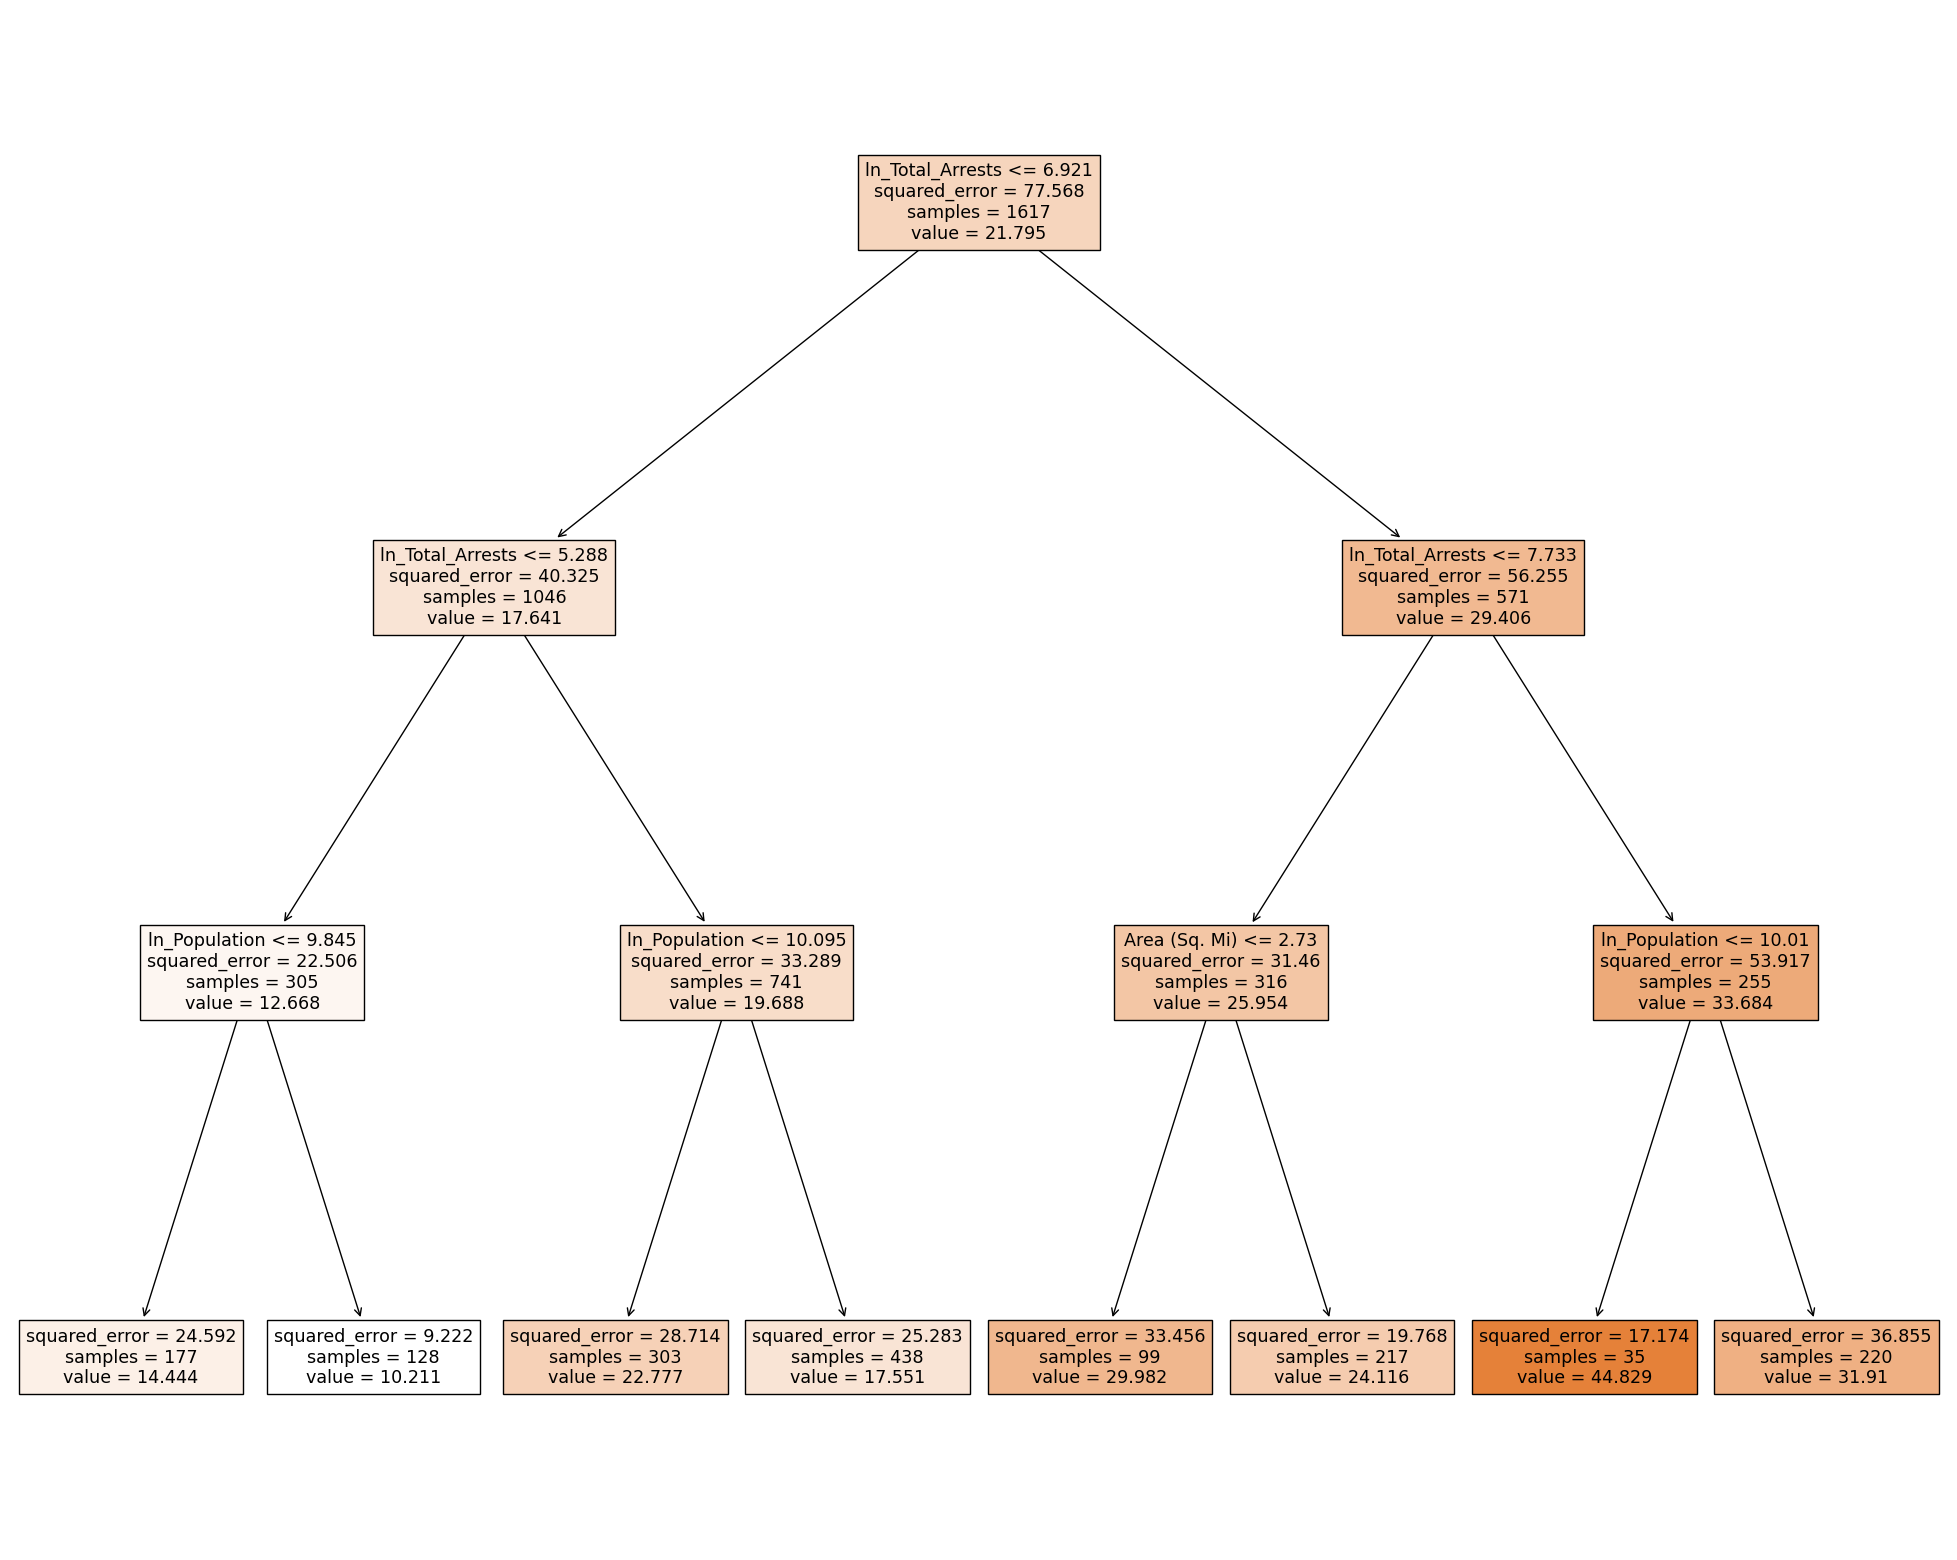

In [224]:
sqrf_fig = plt.figure(figsize=(25,20))
sqrf_fig = tree.plot_tree(sqft_tree, feature_names=X.columns, filled=True)

As compared to Model 3 in my regressions, the Machine Learning model uses 2 of the three variables specified in my model, but adds Area rather than Total reports. However, the model has a higher root MSE of about 25, which is much higher than that of my regression, which is about 2.4.

## Conclusion

In conclusion, this study aimed to investigate the relationship between the successful arrest rate (SAR) in Chicago City and socioeconomic variables relating to all 77 communities over the 2002-2022 period. Using data from the Chicago Police Department, the US Census Bureau, and the Illinois Department of Public Health (IDPH), this study found statistically significant associations between the successful arrest rate and some socioeconomic variables, such as the birth rate, per capita income, the percent of households below poverty, among others. Interestingly, the study also found relatively large associations between the total number of reports, arrests, and the population to the SAR at a highly significant level, indicating that communities with higher numbers of arrests, lower numbers of reports and population are associated with having a higher SAR, which follows general intuition on the matter

It is important to note that the effect sizes of the significant associations were small and may not have significant implications. Therefore, it is crucial to interpret these findings with caution and acknowledge the limitations of this study. For instance, this study was unable to examine any causal relationships between the observed variables, and other factors that were not included in this study could also influence the SAR. 

Moreover, the socioeconomic measures used in the study were constant throughout the study-period, meaning that the data did not account for any change in the values of these socioeconomic variables for the entirety of the study. Future research should explore the complex relationship between socioeconomic variables and successful arrest rates in areas larger than Chicago, while also taking into account potential confounding variables that could affect the results. This is because larger cities, or even countries, would imply access to more socioeconomic variables over a longer period of time, making the study highly more reliable. 

Overall, this study adds to the little existing literature on the relationship between socioeconomic status and crime, and highlights the need for continued research in this area on a larger scale.
